In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import pandas as pd
import collections
import lqg1d
import json

import numba

# Function definitions

In [2]:
def load_dataframe(folder):
    experiments = []
    for experiment in glob.glob(os.path.join(folder, '*_params.json')):
        with open(experiment, 'r') as f:
            params = json.load(f)

        experiments.append({k.upper():i for k,i in params.items()})
    experiments_df = pd.DataFrame(experiments)
    experiments_df = experiments_df.fillna('-')
    
    return experiments_df

In [3]:
def load_from_dataframe(df):
    return [pd.read_pickle(f + '.gzip') for f in df['FILENAME'].values]
        

In [4]:
def filter_experiments(**kwargs):
    df_filtered = kwargs['df']
    for k,v in kwargs.items():
        if v is not None:
            try:
                if isinstance(v, list):
                    df_filtered = df_filtered[df_filtered[k.upper()].isin(v)]
                else:
                    df_filtered = df_filtered[df_filtered[k.upper()] == v]
            except:
                pass
    return df_filtered

In [5]:
def my_plot(**kwargs):
    data_params = filter_experiments(**kwargs)
    
    free_vars = []
    for k,v in kwargs.items():
        if v is None or (k.upper() in data_params.columns and isinstance(v, list)):
            free_vars.append(k)

    free_vars = [s.upper() for s in free_vars]
    
    if len(free_vars) <= 0:
        data_params = data_params.sort_values(by=list(data_params.columns), ascending=False)
    else:
        data_params = data_params.sort_values(by=free_vars, ascending=False)

    data = load_from_dataframe(data_params)

    plt.rcParams["figure.figsize"] = (15,13)
    
    def plot_lines(**kwargs):
        MAX_T = kwargs['max_t'] if 'max_t' in kwargs else -1
        MIN_T = kwargs['min_t'] if 'min_t' in kwargs else 0
        STEP = kwargs['step'] if 'step' in kwargs else 1
        ALPHA = kwargs['alpha'] if 'alpha' in kwargs else 1

        if isinstance(kwargs['value'], list):
            params = kwargs
            ll = len(kwargs['value'])
            i = 1
            for v in kwargs['value']:
                plt.subplot((ll + 1)//2, 2, i)
                i+=1
                params['value'] = v
                plot_lines(**params)
        else:
            for d in data:
                d['J+J_DET'] = d['J'] + d['J_DET']
                d['J_JOURNEY+J_DET'] = d['J_JOURNEY'] + d['J_DET']
                try:
                    x = d['T'].values[MIN_T:MAX_T:STEP] // STEP
                    y = d[kwargs['value']].values[MIN_T:MAX_T:STEP]
                except:
                    x = d['T'].values[MIN_T:MAX_T:STEP] // STEP
                    y = np.zeros(x.shape[0])
                plt.plot(x, y, alpha=ALPHA)
                plt.xlabel('Timesteps')
                plt.ylabel(kwargs['value'])
                plt.title(kwargs['value'])
                
                if kwargs['value'] == 'J+J_DET':
                    plt.plot(x, [d['J+J_DET'][0]]*len(x), 'r-', label='_nolegend_')
                    print('Initial J+J_DET is: ', d['J+J_DET'][0])
                    print('Average J+J_DET is: ', np.average(d['J+J_DET']))
                if kwargs['value'] == 'J_JOURNEY+J_DET':
                    plt.plot(x, [d['J_JOURNEY+J_DET'][0]]*len(x), 'r-', label='_nolegend_')
                if kwargs['value'] == 'BUDGET':
                    plt.plot(x, [0]*len(x), 'r-', label='_nolegend_')
                    print('Budget is negative for: ', sum(d['BUDGET']<0), '/', d['BUDGET'].shape[0], ' times')
                if kwargs['value'] == 'J_JOURNEY':
                    plt.plot(x, [d['J_JOURNEY'][0]]*len(x), 'r-', label='_nolegend_')
                if kwargs['value'] == 'GRAD_DELTAW':
                    plt.plot(x, [0]*len(x), 'r-', label='_nolegend_')

    plot_lines(**kwargs)
    
    # Build legend

    legend = [' '.join(map(lambda x : ': '.join((x[0], x[1] if x[1] is not np.nan else '-')), zip(data_params.loc[:,free_vars].columns.values, s))) for s in data_params.loc[:,free_vars].values]

    plt.legend(legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

        

# Load experiments

In [12]:
BASE_FOLDER = 'EXPERIMENTS_FINAL_LONG/'

experiments_df2 = filter_experiments(df=load_dataframe(BASE_FOLDER), experiment=['ExpBudget_DetPolicy', 'ExpBudget_SemiDetPolicy', 'MonotonicOnlyTheta'])

In [13]:
experiments_df2['ALPHA'] = '-'
experiments_df2['RANDOM_SEED'] = experiments_df2['NAME'].apply(get_random_seed)

In [14]:
experiments_df2['SIGMA'] = '1.0'

In [15]:
ddd = pd.concat([experiments_df, experiments_df2])

In [16]:
ddd['EXPERIMENT'].unique()

array(['Adam', 'NoWorseThanBaselineEveryStep', 'MonotonicNaiveGradient',
       'ExpBudget_NoDetPolicy', 'MonotonicOnlyTheta',
       'ExpBudget_SemiDetPolicy', 'ExpBudget_DetPolicy'], dtype=object)

In [9]:
BASE_FOLDER = 'GRID_LQG_CONFIDENCE/'

experiments_df = load_dataframe(BASE_FOLDER)

In [10]:
def add_learning_rate(x):
    tokens = x.split('_')
    if (tokens[0] == 'Adam') or (tokens[0] == 'MonotonicNaiveGradient'):
        return tokens[1]
    else:
        return '-'

In [11]:
def get_random_seed(x):
    tokens = x.split('_')
    return int(tokens[-1])

In [17]:
experiments_df['ALPHA'] = experiments_df['NAME'].apply(add_learning_rate)

In [18]:
experiments_df['RANDOM_SEED'] = experiments_df['NAME'].apply(get_random_seed)

In [19]:
ddd['EXPERIMENT'].unique()

array(['Adam', 'NoWorseThanBaselineEveryStep', 'MonotonicNaiveGradient',
       'ExpBudget_NoDetPolicy', 'MonotonicOnlyTheta',
       'ExpBudget_SemiDetPolicy', 'ExpBudget_DetPolicy'], dtype=object)

In [20]:
experiments_df

APPROXIMATE_GRADIENTS DELTA                    EXPERIMENT  \
0                    True   0.9                          Adam   
1                    True   0.9  NoWorseThanBaselineEveryStep   
2                    True   0.9        MonotonicNaiveGradient   
3                    True   0.9                          Adam   
4                    True   0.9         ExpBudget_NoDetPolicy   
5                    True   0.9        MonotonicNaiveGradient   
6                    True   0.9                          Adam   
7                    True   0.9                          Adam   
8                    True   0.9        MonotonicNaiveGradient   
9                    True   0.9        MonotonicNaiveGradient   
10                   True   0.9                          Adam   
11                   True   0.9        MonotonicNaiveGradient   
12                   True   0.9                          Adam   
13                   True   0.9            MonotonicOnlyTheta   
14                   True   0.9                          Adam   
15                   True   0.9        MonotonicNaiveGradient   
16                   True   0.9                          Adam   
17                   True   0.9        MonotonicNaiveGradient   
18                   True   0.9        MonotonicNaiveGradient   
19                   True   0.9                          Adam   
20                   True   0.9        MonotonicNaiveGradient   
21                   True   0.9        MonotonicNaiveGradient   
22                   True   0.9        MonotonicNaiveGradient   
23                   True   0.9                          Adam   
24                   True   0.9                          Adam   
25                   True   0.9                          Adam   
26                   True   0.9        MonotonicNaiveGradient   
27                   True   0.9        MonotonicNaiveGradient   
28                   True   0.9                          Adam   
29                   True   0.9        MonotonicNaiveGradient   
..                    ...   ...                           ...   
425                  True   0.9            MonotonicOnlyTheta   
426                  True   0.9        MonotonicNaiveGradient   
427                  True   0.9                          Adam   
428                  True   0.9            MonotonicOnlyTheta   
429                  True   0.9                          Adam   
430                  True   0.9        MonotonicNaiveGradient   
431                  True   0.9        MonotonicNaiveGradient   
432                  True   0.9                          Adam   
433                  True   0.9        MonotonicNaiveGradient   
434                  True   0.9        MonotonicNaiveGradient   
435                  True   0.9                          Adam   
436                  True   0.9        MonotonicNaiveGradient   
437                  True   0.9            MonotonicOnlyTheta   
438                  True   0.9                          Adam   
439                  True   0.9  NoWorseThanBaselineEveryStep   
440                  True   0.9        MonotonicNaiveGradient   
441                  True   0.9                          Adam   
442                  True   0.9        MonotonicNaiveGradient   
443                  True   0.9  NoWorseThanBaselineEveryStep   
444                  True   0.9            MonotonicOnlyTheta   
445                  True   0.9        MonotonicNaiveGradient   
446                  True   0.9        MonotonicNaiveGradient   
447                  True   0.9        MonotonicNaiveGradient   
448                  True   0.9        MonotonicNaiveGradient   
449                  True   0.9                          Adam   
450                  True   0.9        MonotonicNaiveGradient   
451                  True   0.9                          Adam   
452                  True   0.9                          Adam   
453                  True   0.9                          Adam   
454                  True   0.9        

In [21]:
newdf = filter_experiments(df=experiments_df2, sigma='1.0')

In [22]:
def get_avg_col(column):
    def get_average(x):
        return pd.DataFrame([x[column] for x in load_from_dataframe(x)]).mean().values
    return get_average

In [23]:
def get_std_col(column):
    def get_std(x):
        if column == 'J+J_DET':
            means_j = [x['J'] for x in load_from_dataframe(x)]
            means_jdet = [x['J_DET'] for x in load_from_dataframe(x)]
            return pd.DataFrame(a+b for a,b in zip(means_j, means_jdet)).std().values
        else:
            return pd.DataFrame([x[column] for x in load_from_dataframe(x)]).std().values
    return get_std

In [165]:
average_J = newdf.groupby(['EXPERIMENT']).apply(get_avg_col('J'))

In [166]:
std_J = newdf.groupby(['EXPERIMENT']).apply(get_std_col('J'))

In [24]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [218]:
average_J

EXPERIMENT
ExpBudget_DetPolicy        [-85.77709538618065, -88.72741049143903, -87.5...
ExpBudget_SemiDetPolicy    [-85.93608564397317, -86.54848804113408, -87.5...
MonotonicOnlyTheta         [-85.93608564397316, -88.10824004023563, -87.9...
dtype: object

In [32]:
plt.tight_layout()

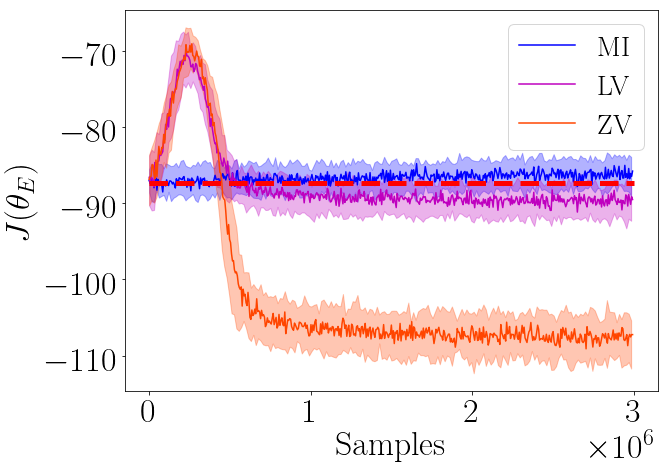

In [52]:
plt.figure(figsize=(10,7))
plt.gcf().subplots_adjust(left=0.16)
average_J = newdf.groupby(['EXPERIMENT']).apply(get_avg_col('J'))
std_J = newdf.groupby(['EXPERIMENT']).apply(get_std_col('J'))

colors = ['b', 'm', 'orangered']

step_mean = 20
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['MonotonicOnlyTheta', 'ExpBudget_SemiDetPolicy', 'ExpBudget_DetPolicy']
plt.rc('text', usetex=True)
plt.rc('font', size=34)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(average_J[name], ma_mean)
    means_stds = moving_average(average_J[name], ma_var)
    stds = moving_average(std_J[name], ma_var)
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-stds)[::step_var], (means_stds+stds)[::step_var], alpha=0.3, color=c)
plt.plot([0,300*10000], np.ones(2) * -87.3, 'r--', linewidth=5)
    
plt.ylabel('$J(\\theta_{E})$')
plt.xlabel('Samples')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(['MI', 'LV', 'ZV'], loc=1,  prop={'size': 28})
plt.xticks([0, 1e06, 2e06, 3e06])

plt.savefig('plot1.pdf')

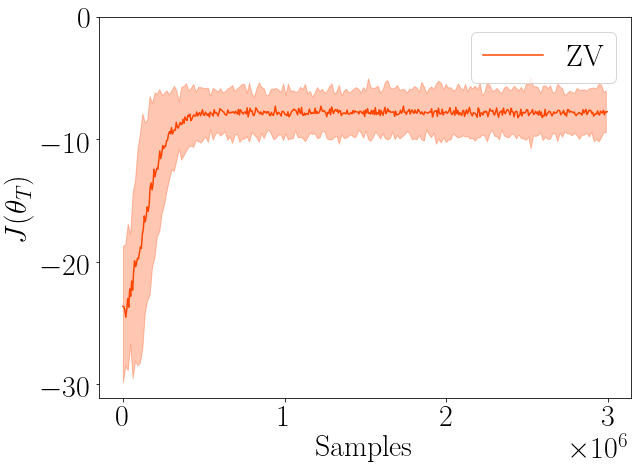

In [40]:
plt.figure(figsize=(10,7))
plt.gcf().subplots_adjust(left=0.16)
average_J = newdf.groupby(['EXPERIMENT']).apply(get_avg_col('J_DET'))
std_J = newdf.groupby(['EXPERIMENT']).apply(get_std_col('J_DET'))

colors = ['orangered']

K=3

step_mean = 20
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['ExpBudget_DetPolicy']
plt.rc('text', usetex=True)
plt.rc('font', size=30)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(average_J[name], ma_mean)
    means_stds = moving_average(average_J[name], ma_var)
    stds = moving_average(std_J[name], ma_var)
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-K*stds)[::step_var], (means_stds+K*stds)[::step_var], alpha=0.3, color=c)
    
plt.ylabel(r'$J(\theta_{T})$')
plt.xlabel('Samples')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(['ZV'])
plt.xticks([0, 1e06, 2e06, 3e06])
plt.yticks([-30, -20, -10, 0])
plt.savefig('plot2.pdf')

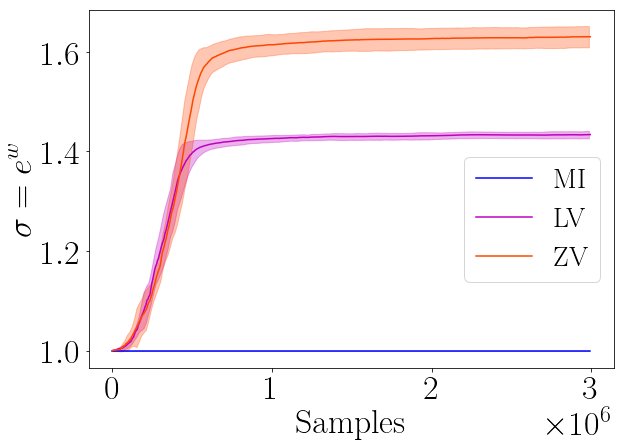

In [61]:
plt.figure(figsize=(10,7))
plt.gcf().subplots_adjust(left=0.17, bottom=0.17)
average_J = newdf.groupby(['EXPERIMENT']).apply(get_avg_col('SIGMA'))
std_J = newdf.groupby(['EXPERIMENT']).apply(get_std_col('SIGMA'))

colors = ['b', 'm', 'orangered']

step_mean = 20
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['MonotonicOnlyTheta', 'ExpBudget_SemiDetPolicy', 'ExpBudget_DetPolicy']
plt.rc('text', usetex=True)
plt.rc('font', size=34)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(average_J[name], ma_mean)
    means_stds = moving_average(average_J[name], ma_var)
    stds = moving_average(std_J[name], ma_var)
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-stds)[::step_var], (means_stds+stds)[::step_var], alpha=0.3, color=c)
    
plt.ylabel('$\\sigma=e^w$')
plt.xlabel('Samples')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(['MI', 'LV', 'ZV'], loc=4, bbox_to_anchor=(1, 0.2),  prop={'size': 28})
plt.xticks([0, 1e06, 2e06, 3e06])
plt.yticks([1.0, 1.2, 1.4, 1.6])
plt.savefig('plot3.pdf')

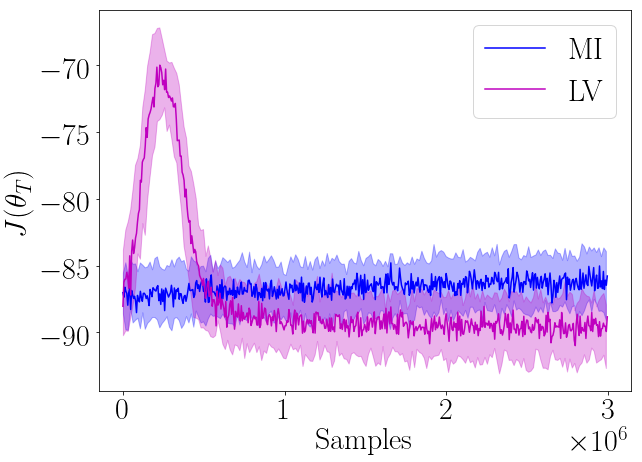

In [43]:
means_monotonic = newdf.groupby(['EXPERIMENT']).apply(get_avg_col('J'))['MonotonicOnlyTheta']
stds_monotonic = newdf.groupby(['EXPERIMENT']).apply(get_std_col('J'))['MonotonicOnlyTheta']

plt.figure(figsize=(10,7))
plt.gcf().subplots_adjust(left=0.16)
average_J = newdf.groupby(['EXPERIMENT']).apply(get_avg_col('J_DET'))
std_J = newdf.groupby(['EXPERIMENT']).apply(get_std_col('J_DET'))

colors = ['b', 'm', 'orangered']

step_mean = 20
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['MonotonicOnlyTheta', 'ExpBudget_SemiDetPolicy']
plt.rc('text', usetex=True)
plt.rc('font', size=30)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(average_J[name], ma_mean)
    means_stds = moving_average(average_J[name], ma_var)
    stds = moving_average(std_J[name], ma_var)
    
    if name == 'MonotonicOnlyTheta':
        means = moving_average(means_monotonic, ma_mean)
        means_stds = moving_average(means_monotonic, ma_var)
        stds = moving_average(stds_monotonic, ma_var)
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-stds)[::step_var], (means_stds+stds)[::step_var], alpha=0.3, color=c)

    
plt.ylabel(r'$J(\theta_{T})$')
plt.xlabel('Samples')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks([0, 1e06, 2e06, 3e06])
plt.legend(['MI', 'LV'])

plt.savefig('plot4.pdf')

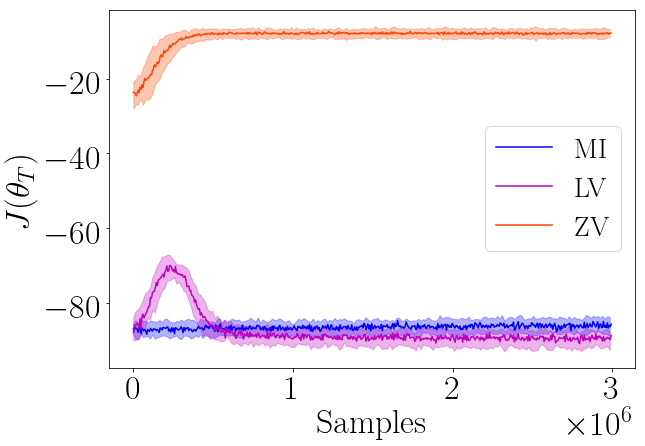

In [63]:
means_monotonic = newdf.groupby(['EXPERIMENT']).apply(get_avg_col('J'))['MonotonicOnlyTheta']
stds_monotonic = newdf.groupby(['EXPERIMENT']).apply(get_std_col('J'))['MonotonicOnlyTheta']

plt.figure(figsize=(10,7))
plt.gcf().subplots_adjust(left=0.17, bottom=0.17)
average_J = newdf.groupby(['EXPERIMENT']).apply(get_avg_col('J_DET'))
std_J = newdf.groupby(['EXPERIMENT']).apply(get_std_col('J_DET'))

colors = ['b', 'm', 'orangered']

step_mean = 20
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['MonotonicOnlyTheta', 'ExpBudget_SemiDetPolicy', 'ExpBudget_DetPolicy']
plt.rc('text', usetex=True)
plt.rc('font', size=34)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(average_J[name], ma_mean)
    means_stds = moving_average(average_J[name], ma_var)
    stds = moving_average(std_J[name], ma_var)
    
    if name == 'MonotonicOnlyTheta':
        means = moving_average(means_monotonic, ma_mean)
        means_stds = moving_average(means_monotonic, ma_var)
        stds = moving_average(stds_monotonic, ma_var)
    elif name == 'ExpBudget_DetPolicy':
        stds*=2
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-stds)[::step_var], (means_stds+stds)[::step_var], alpha=0.3, color=c)

    
plt.ylabel(r'$J(\theta_{T})$')
plt.xlabel('Samples')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks([0, 1e06, 2e06, 3e06])
plt.legend(['MI', 'LV', 'ZV'], prop={'size' : 28})

plt.savefig('plot5.pdf')

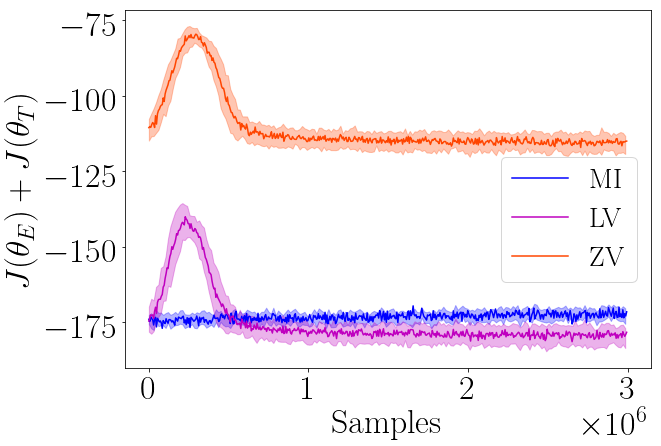

In [64]:
means_monotonic = 2*newdf.groupby(['EXPERIMENT']).apply(get_avg_col('J'))['MonotonicOnlyTheta']
stds_monotonic = newdf.groupby(['EXPERIMENT']).apply(get_std_col('J'))['MonotonicOnlyTheta']


plt.figure(figsize=(10,7))
plt.gcf().subplots_adjust(left=0.17, bottom=0.17)
average_J = newdf.groupby(['EXPERIMENT']).apply(get_avg_col('J')) + newdf.groupby(['EXPERIMENT']).apply(get_avg_col('J_DET'))
std_J = newdf.groupby(['EXPERIMENT']).apply(get_std_col('J+J_DET'))

colors = ['b', 'm', 'orangered']

step_mean = 20
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['MonotonicOnlyTheta', 'ExpBudget_SemiDetPolicy', 'ExpBudget_DetPolicy']
plt.rc('text', usetex=True)
plt.rc('font', size=34)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(average_J[name], ma_mean)
    means_stds = moving_average(average_J[name], ma_var)
    stds = moving_average(std_J[name], ma_var)
    
    if name == 'MonotonicOnlyTheta':
        means = moving_average(means_monotonic, ma_mean)
        means_stds = moving_average(means_monotonic, ma_var)
        stds = moving_average(stds_monotonic, ma_var)
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-stds)[::step_var], (means_stds+stds)[::step_var], alpha=0.3, color=c)

    
plt.ylabel('$J(\\theta_{E}) + J(\\theta_{T})$')
plt.xlabel('Samples')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks([0, 1e06, 2e06, 3e06])
plt.legend(['MI', 'LV', 'ZV'],loc=4, bbox_to_anchor=(1, 0.2), prop={'size':28})

plt.savefig('plot6.pdf')

## Results

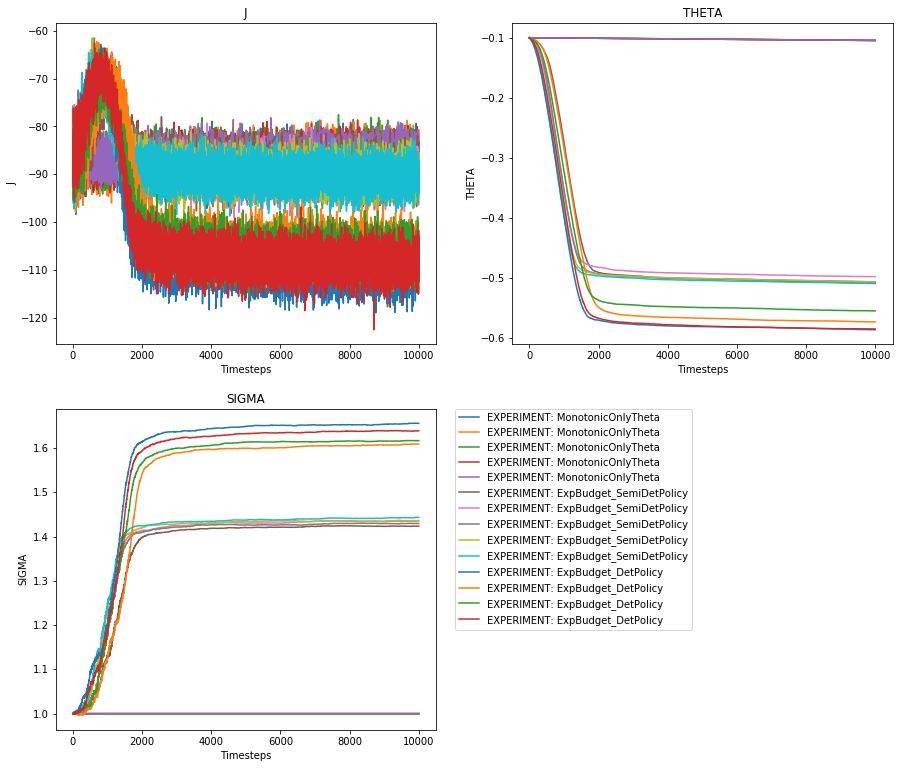

In [160]:
my_plot(theta='-0.1', 
        experiment=['MonotonicOnlyTheta', 'ExpBudget_DetPolicy', 'ExpBudget_SemiDetPolicy'],
        sigma='1.0',
        value=['J', 'THETA', 'SIGMA'], 
        min_t = 0,
        max_t = -1,
        df = experiments_df2)

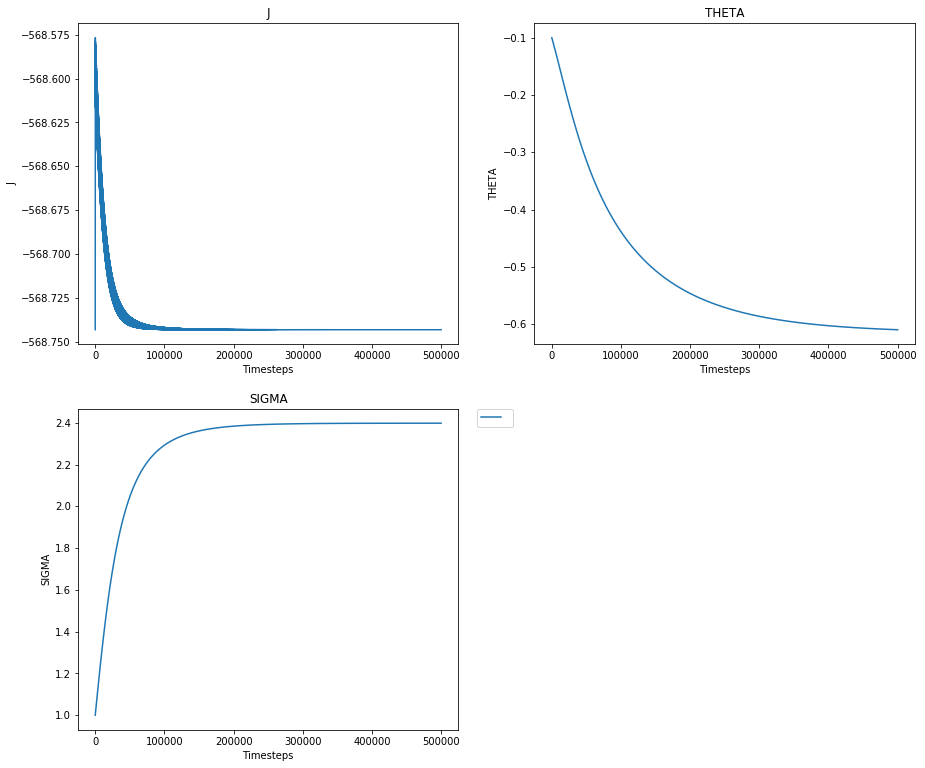

In [9]:
my_plot(lambda_coeff='-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment='ExpSafeConstraintBaseline_two_steps',
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA'], 
        max_t=-1,
        df = experiments_df)

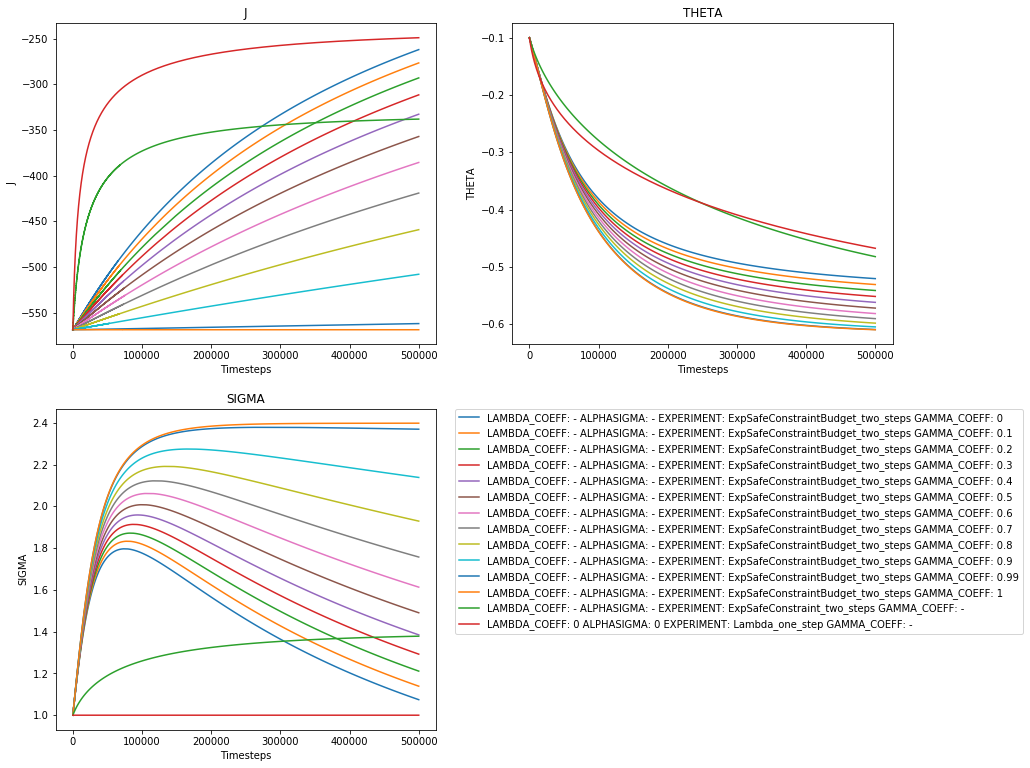

In [10]:
my_plot(lambda_coeff = ['-', '0'], 
        theta='-0.1', 
        alphaSigma = ['-', '0'], 
        experiment=['ExpSafeConstraintBudget_two_steps', 'ExpSafeConstraint_two_steps', 'Lambda_one_step'],
        gamma_coeff=None,
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA'], 
        max_t=-1,
        df = experiments_df)

# Experiments long

In [55]:
BASE_FOLDER = 'experiments_long'

experiments_df = load_dataframe(BASE_FOLDER)

## Results mixed

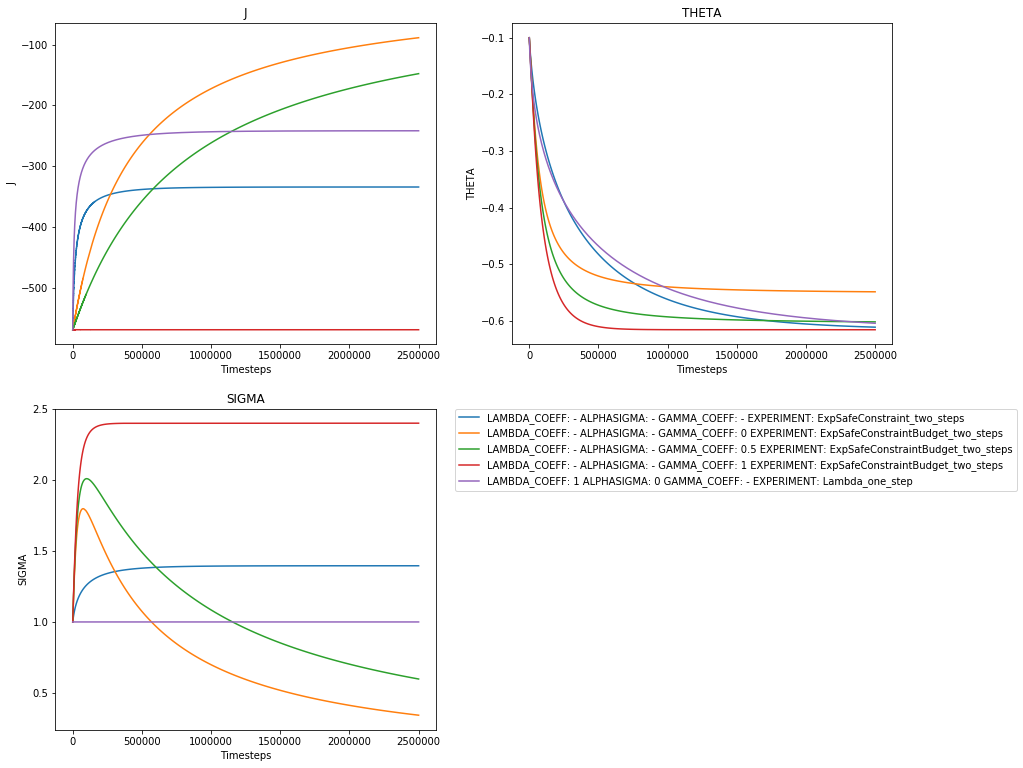

In [16]:
my_plot(lambda_coeff=['-', '1'], 
        theta='-0.1', 
        alphaSigma = ['-', '0'], 
        gamma_coeff = ['0', '0.5','1','-'],
        experiment=['ExpSafeConstraintBudget_two_steps', 'Lambda_one_step', 'ExpSafeConstraint_two_steps'],
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA'], 
        min_t = 0,
        max_t = -1,
        df = experiments_df)

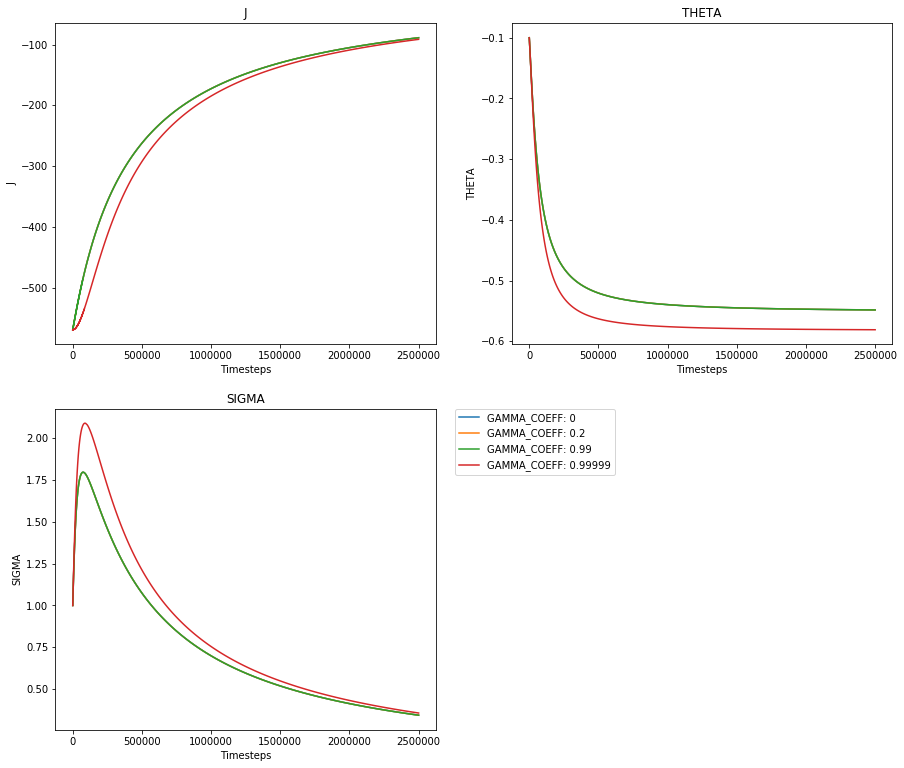

In [20]:
my_plot(lambda_coeff='-', 
        theta='-0.1', 
        alphaSigma = '-', 
        gamma_coeff = ['0', '0.2', '0.99', '0.99999'],
        experiment='ExpSafeConstraintBudget_new',
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA'], 
        min_t = 0,
        max_t = -1,
        df = experiments_df)

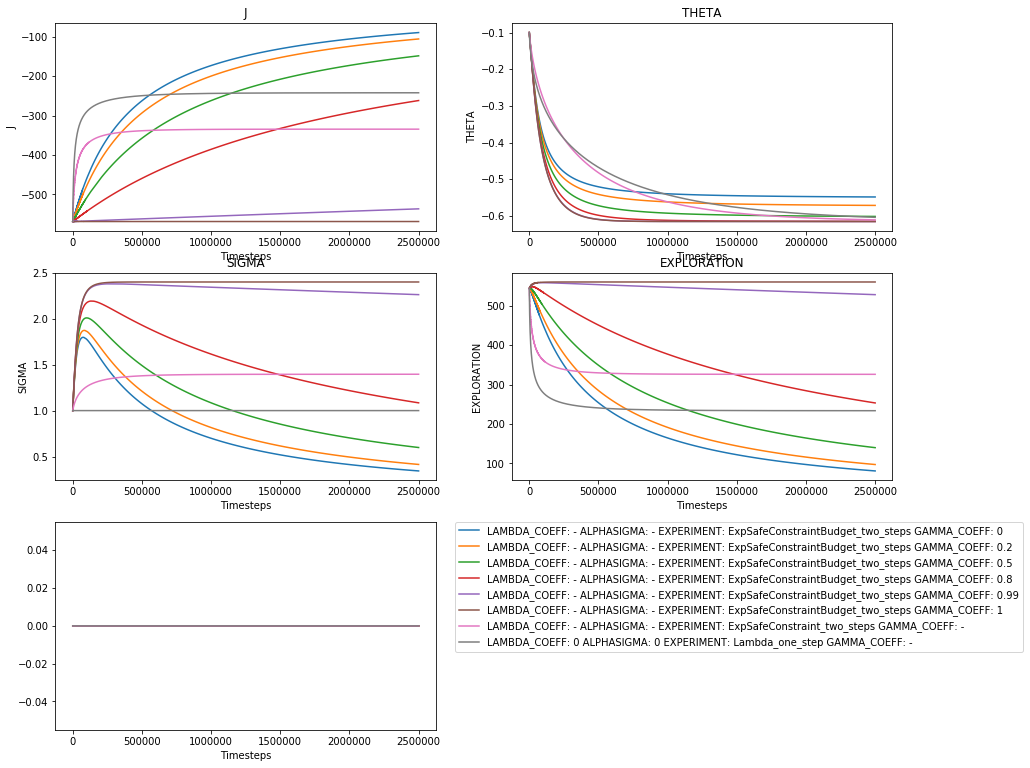

In [188]:
my_plot(lambda_coeff = ['-', '0'], 
        theta='-0.1', 
        alphaSigma = ['-', '0'], 
        experiment=['ExpSafeConstraintBudget_two_steps', 'ExpSafeConstraint_two_steps', 'Lambda_one_step'],
        gamma_coeff=None,
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'EXPLORATION', ''], 
        max_t=-1,
        df = experiments_df)

## Deterministic policy

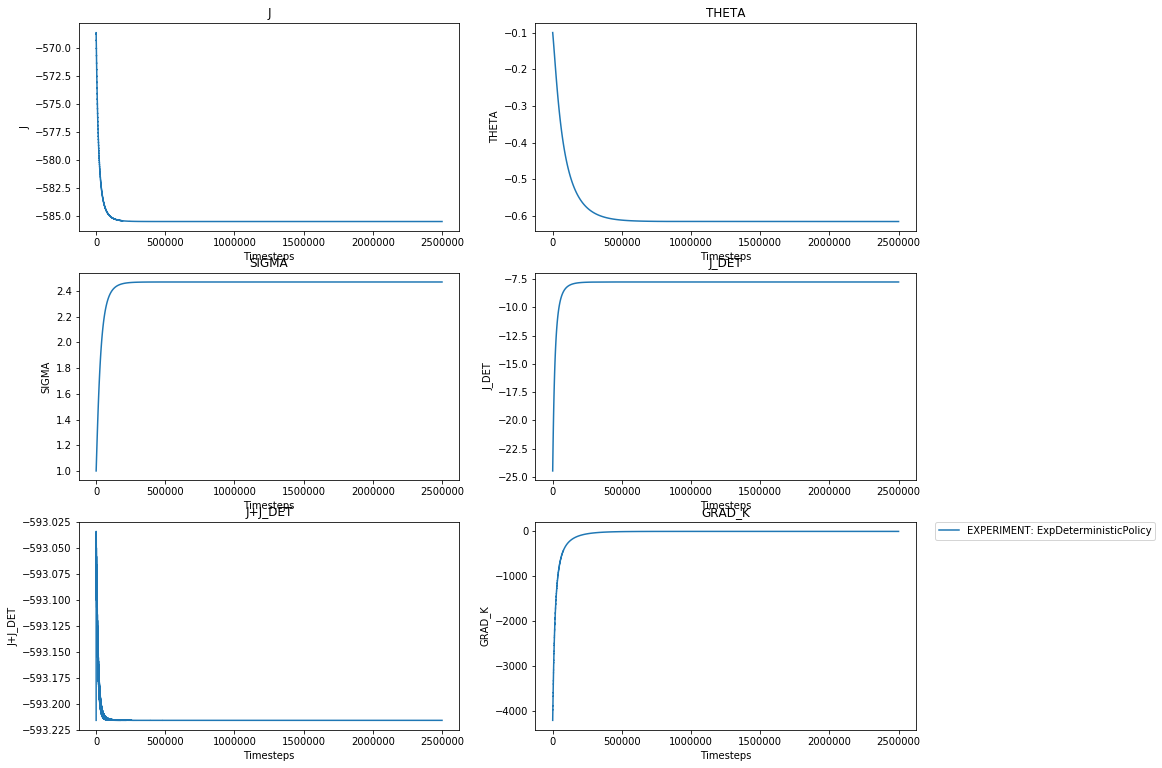

In [27]:
my_plot(lambda_coeff='-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment=['ExpDeterministicPolicy'],
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'J_DET', 'J+J_DET', 'GRAD_K'], 
        max_t=-1,
        df = experiments_df)

## Comparison with discounted deterministic policy

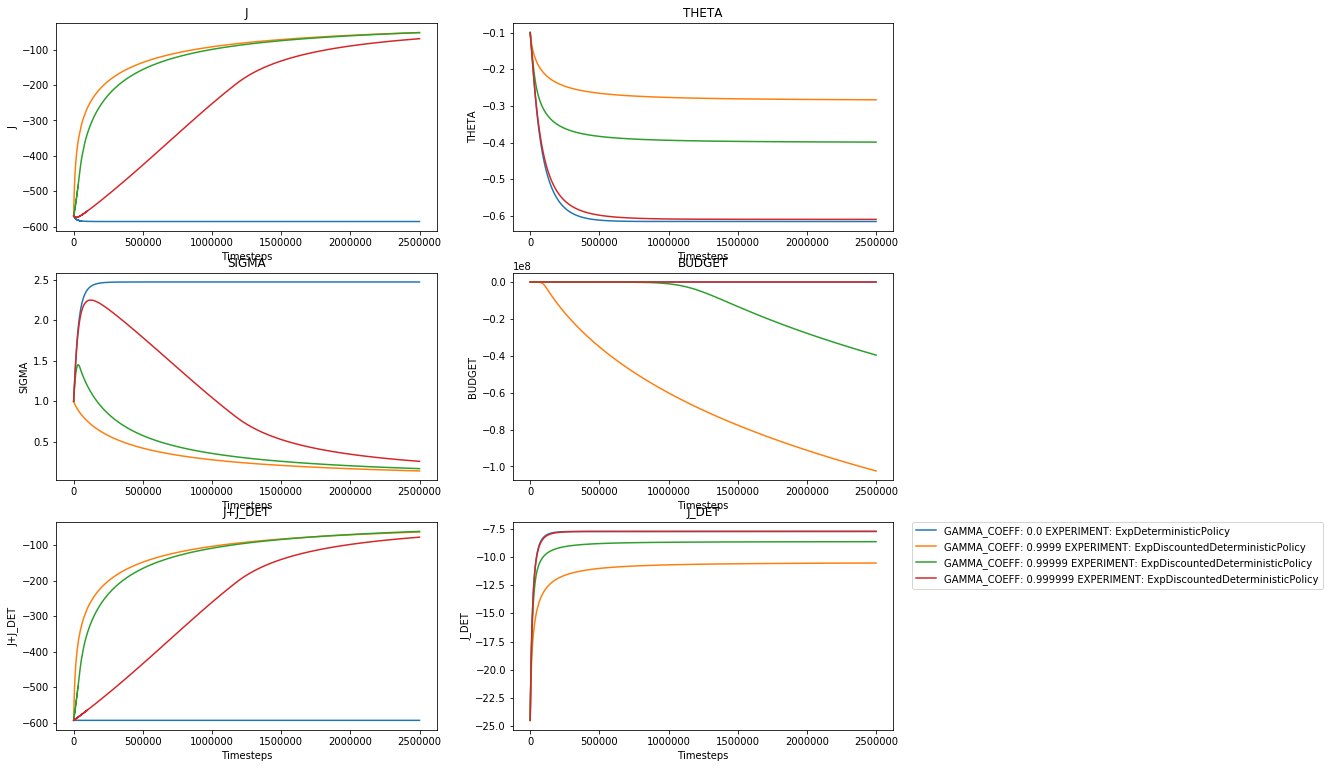

In [33]:
my_plot(lambda_coeff='-', 
        theta='-0.1', 
        alphaSigma = '-', 
        gamma_coeff = None,
        experiment=['ExpDiscountedDeterministicPolicy', 'ExpDeterministicPolicy'],
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'BUDGET', 'J+J_DET', 'J_DET'], 
        min_t = 0,
        max_t = -1,
        df = experiments_df)

## Fixed cost deterministic policy

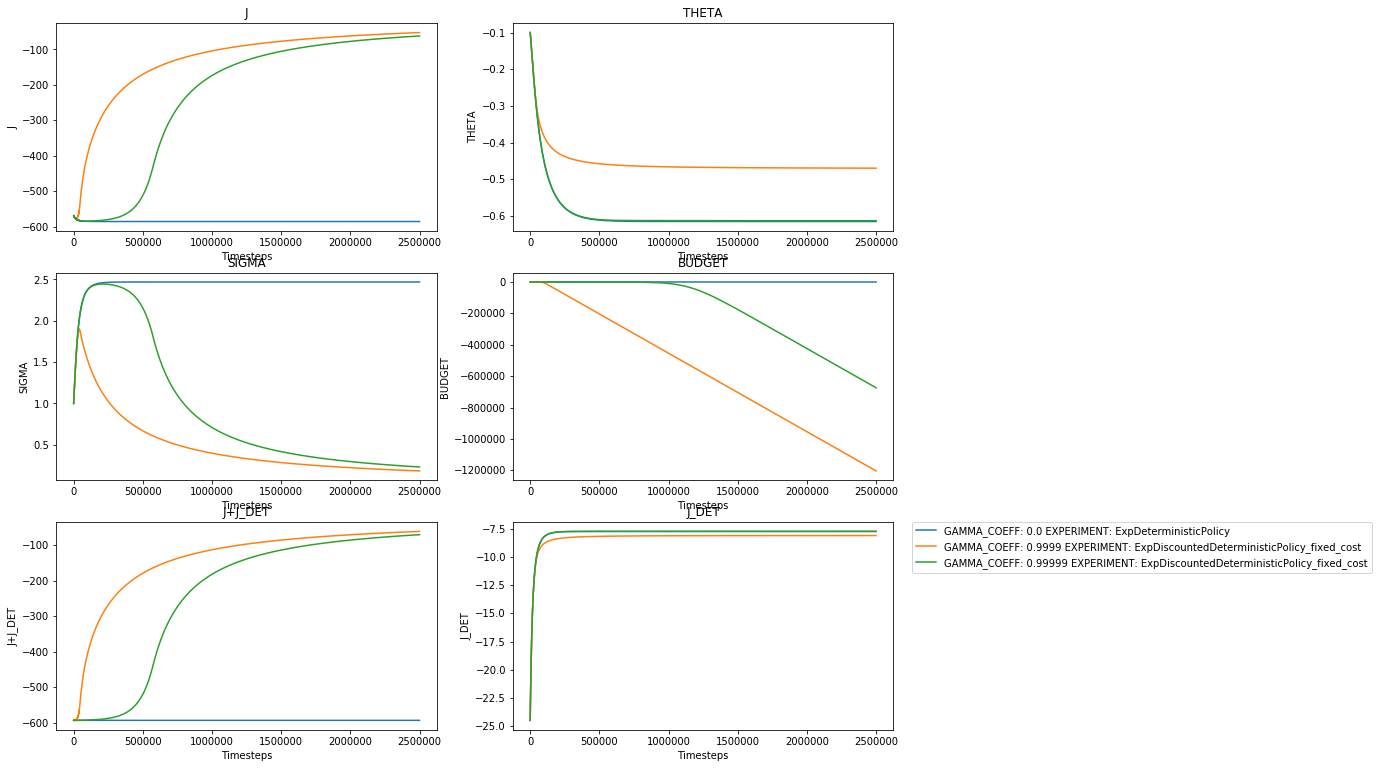

In [36]:
my_plot(lambda_coeff='-', 
        theta='-0.1', 
        alphaSigma = '-', 
        gamma_coeff = None,
        experiment=['ExpDiscountedDeterministicPolicy_fixed_cost', 'ExpDeterministicPolicy'],
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'BUDGET', 'J+J_DET', 'J_DET'], 
        min_t = 0,
        max_t = -1,
        df = experiments_df)

## Experiments with random baselines

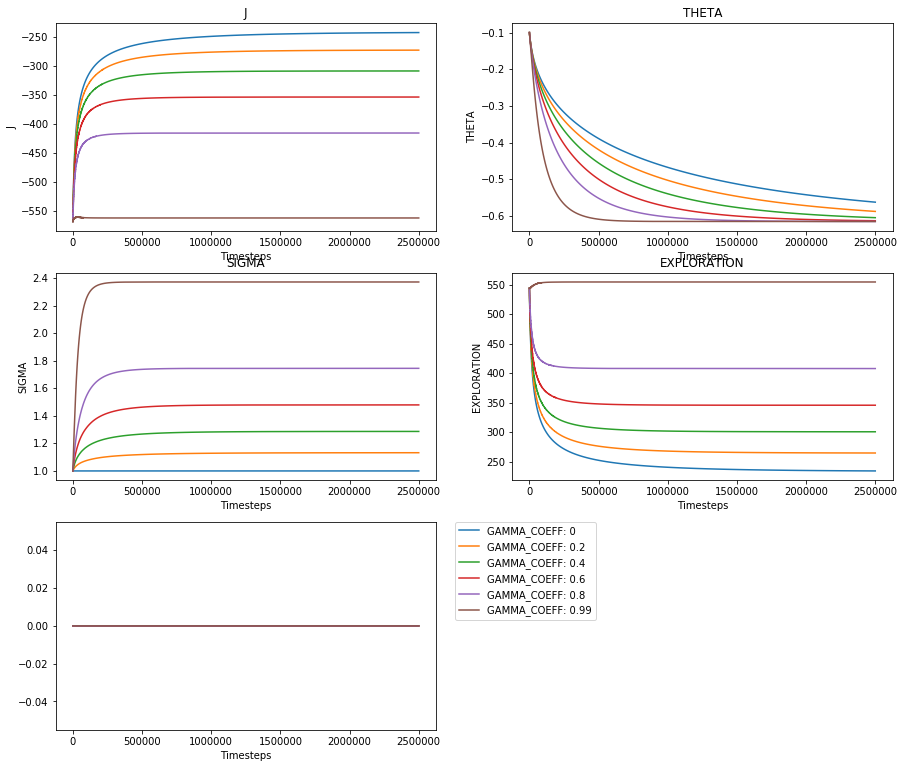

In [54]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment='ExpProbablyDeterministicPolicyBaseline',
        gamma_coeff=None,
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'EXPLORATION', ''], 
        max_t=-1,
        df = experiments_df)

## Experiments with constant online factor

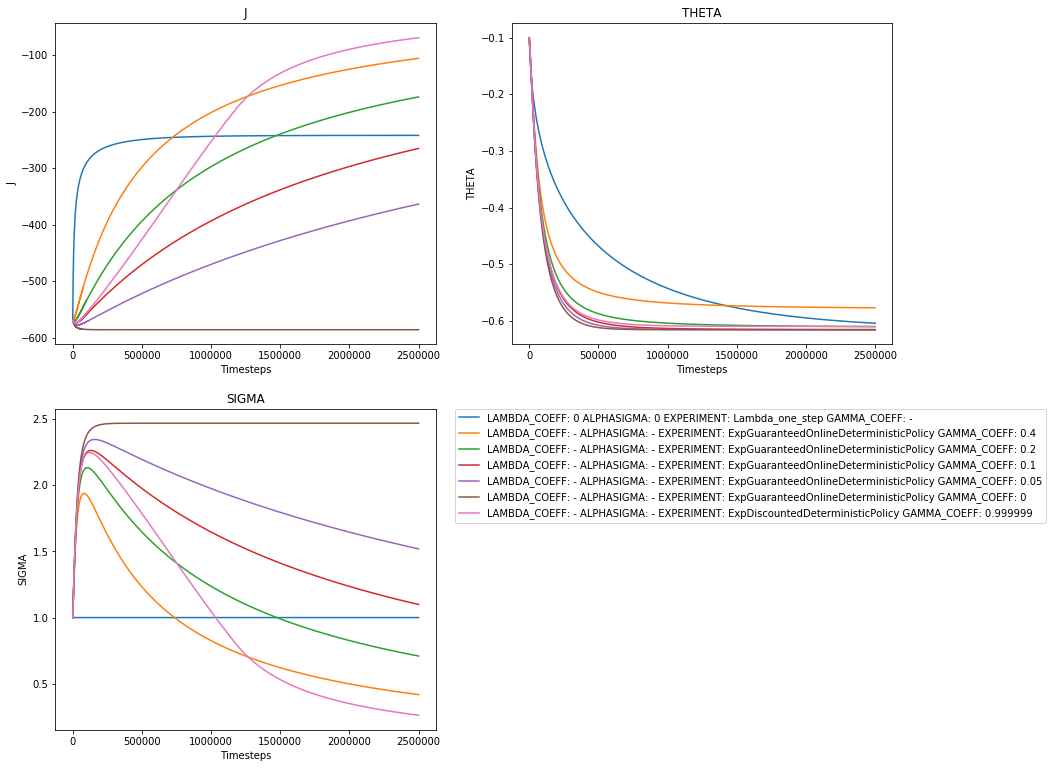

In [152]:
my_plot(lambda_coeff = ['0', '-'], 
        theta='-0.1', 
        alphaSigma = ['0', '-'], 
        experiment=['ExpGuaranteedOnlineDeterministicPolicy', 'Lambda_one_step', 'ExpDiscountedDeterministicPolicy'],
        gamma_coeff=['0', '0.05', '0.1', '0.2', '0.4', '0.999999', '-'],
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA'], 
        max_t=-1,
        df = experiments_df)

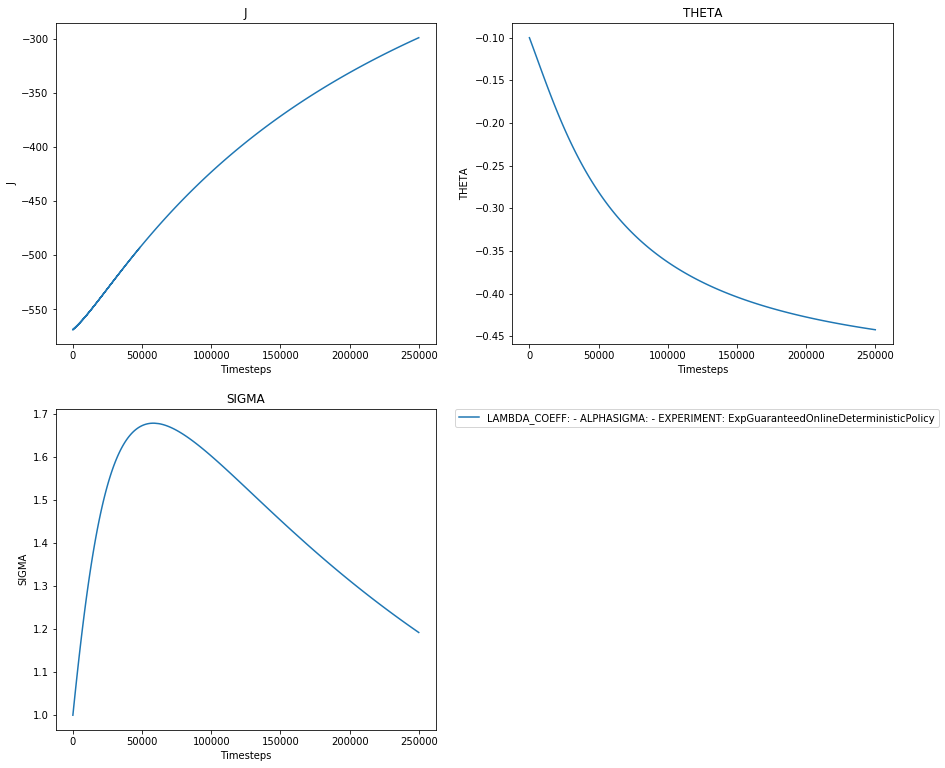

In [154]:
my_plot(lambda_coeff = ['0', '-'], 
        theta='-0.1', 
        alphaSigma = ['0', '-'], 
        experiment=['ExpGuaranteedOnlineDeterministicPolicy', 'Lambda_one_step', 'ExpDiscountedDeterministicPolicy'],
        gamma_coeff='0.8',
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA'], 
        max_t=250000,
        df = experiments_df)

## Experiments with discounted guaranteed online factor

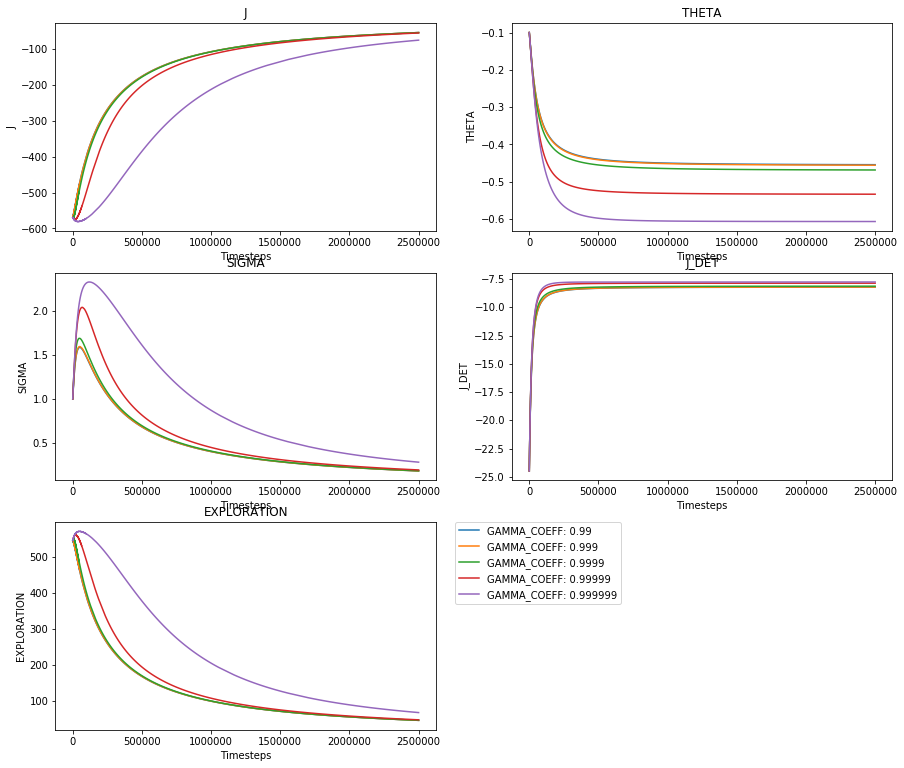

In [79]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment='ExpDiscountedGuaranteedOnlineDeterministicPolicy',
        gamma_coeff=None,
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'J_DET', 'EXPLORATION'], 
        max_t=-1,
        df = experiments_df)

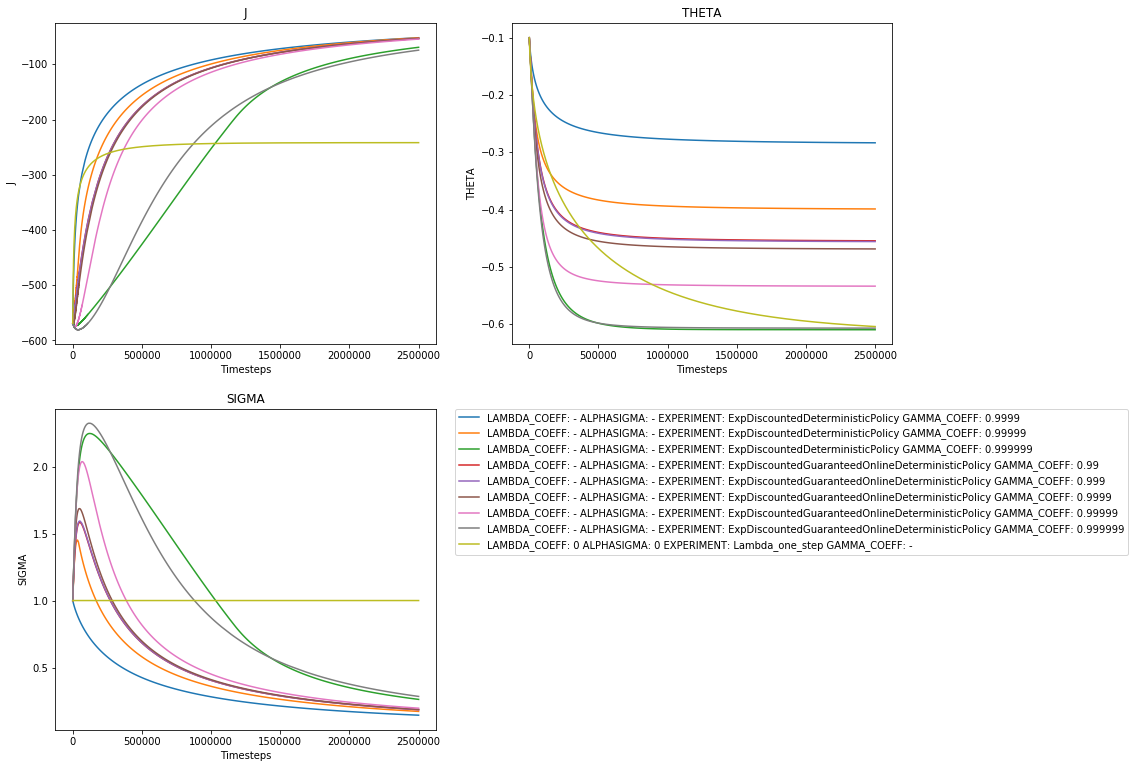

In [76]:
my_plot(lambda_coeff = ['0', '-'], 
        theta='-0.1', 
        alphaSigma = ['0', '-'], 
        experiment=['ExpDiscountedGuaranteedOnlineDeterministicPolicy', 'Lambda_one_step', 'ExpDiscountedDeterministicPolicy'],
        gamma_coeff=None,
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA'], 
        max_t=-1,
        df = experiments_df)

## Experiments with early stopping conditions

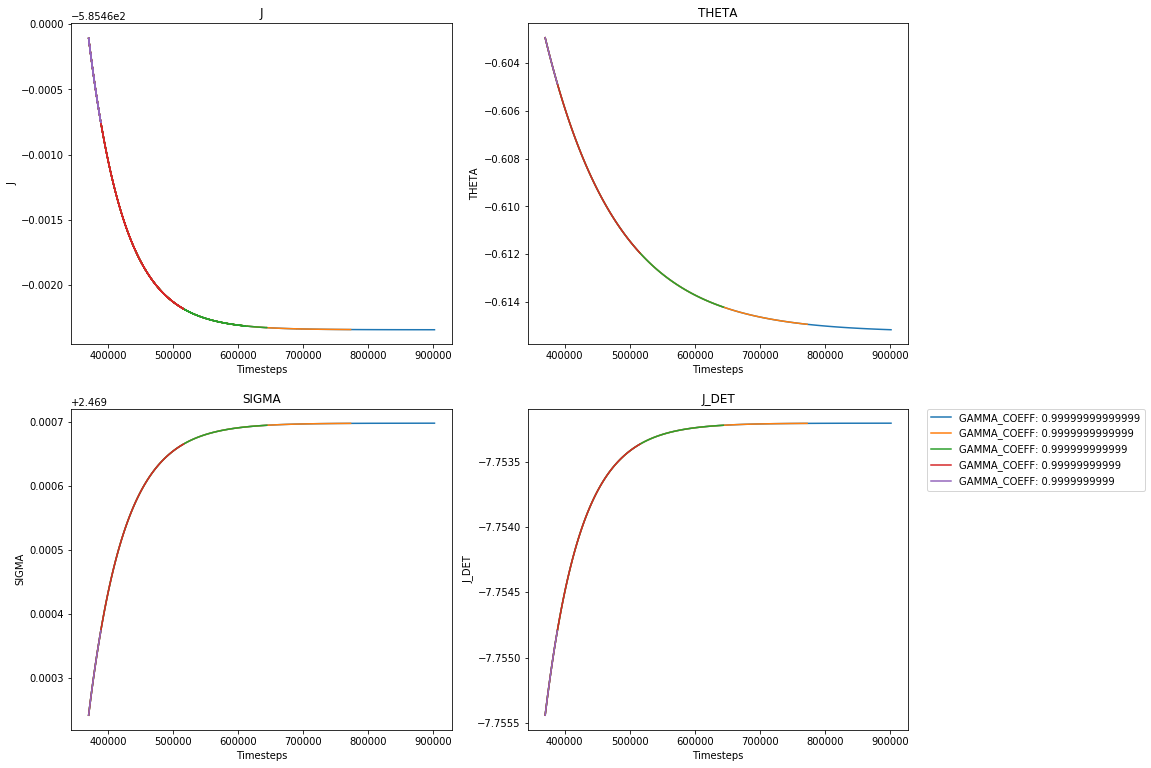

In [96]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment='ExpEarlyStoppingCondition',
        gamma_coeff=None,
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'J_DET'], 
        min_t = 370000,
        max_t=-1,
        df = experiments_df)

## Experiments with ExpBudgetReductionStopCondition

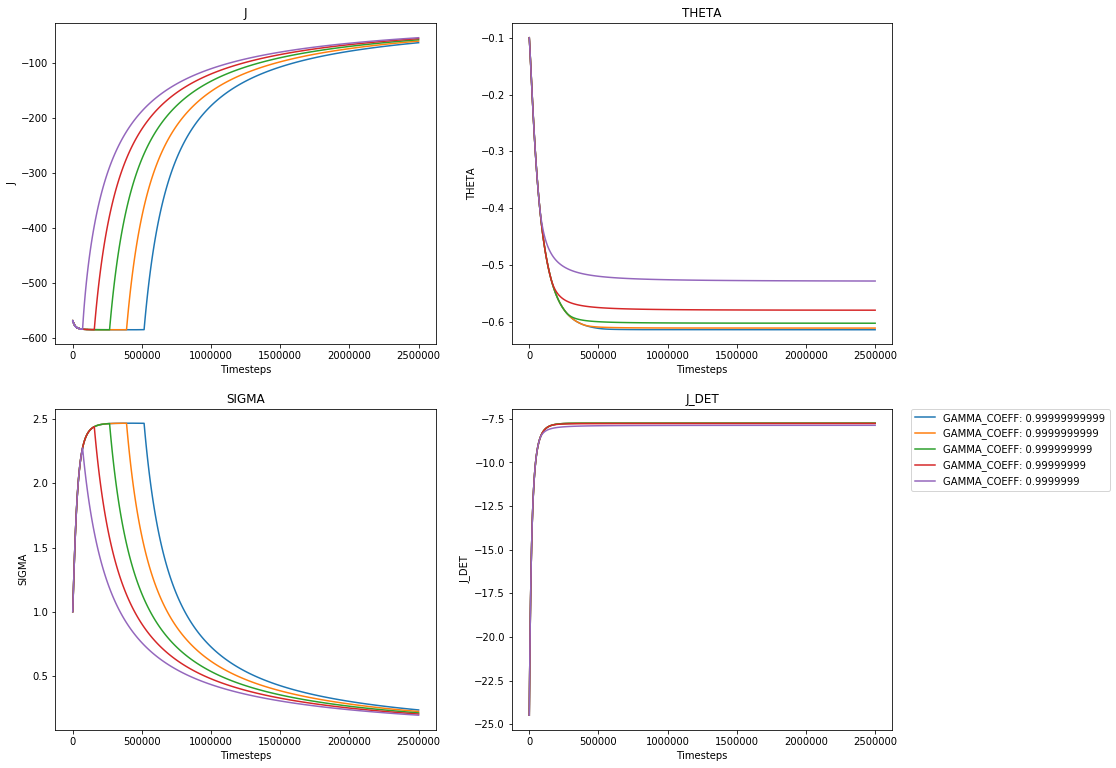

In [102]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment='ExpBudgetReductionStopCondition',
        gamma_coeff=None,
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'J_DET'], 
        min_t = 0,
        max_t=-1,
        df = experiments_df)

## Experiments with alpha and beta

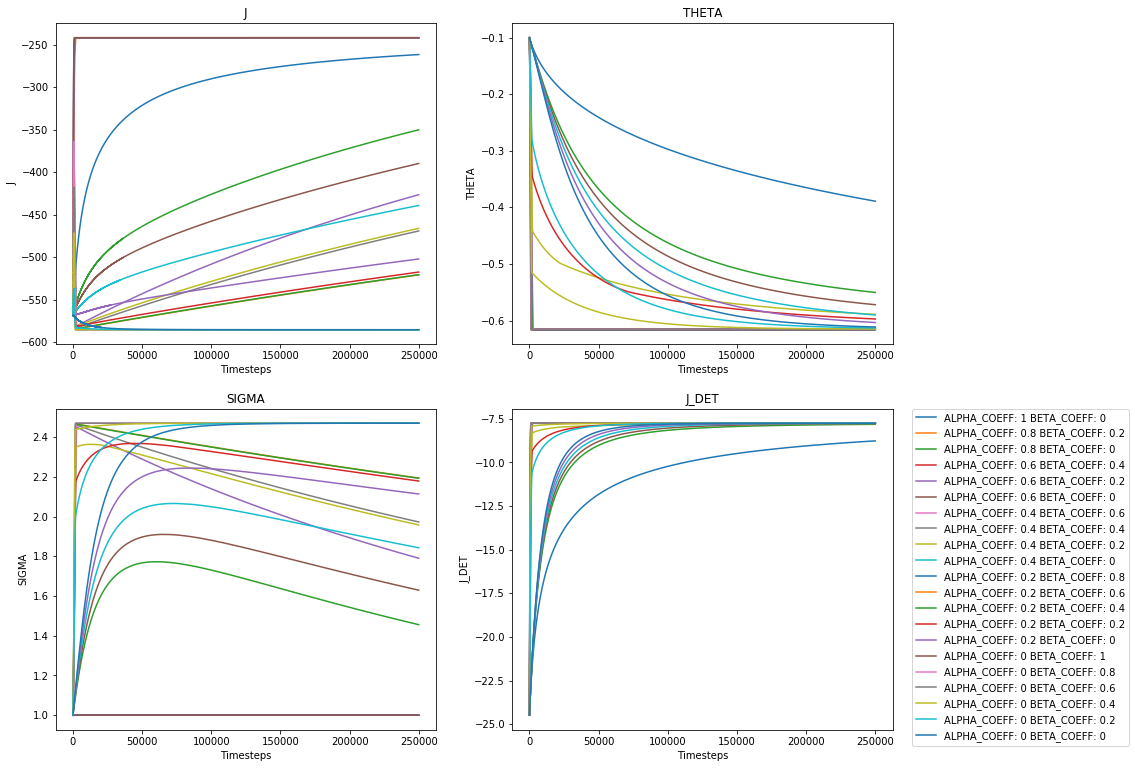

In [158]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        alpha_coeff = None,
        beta_coeff = None,
        experiment='ExpThetaAndSigmaBudget',
        gamma_coeff='-',
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'J_DET'], 
        min_t = 0,
        max_t=-1,
        df = experiments_df)

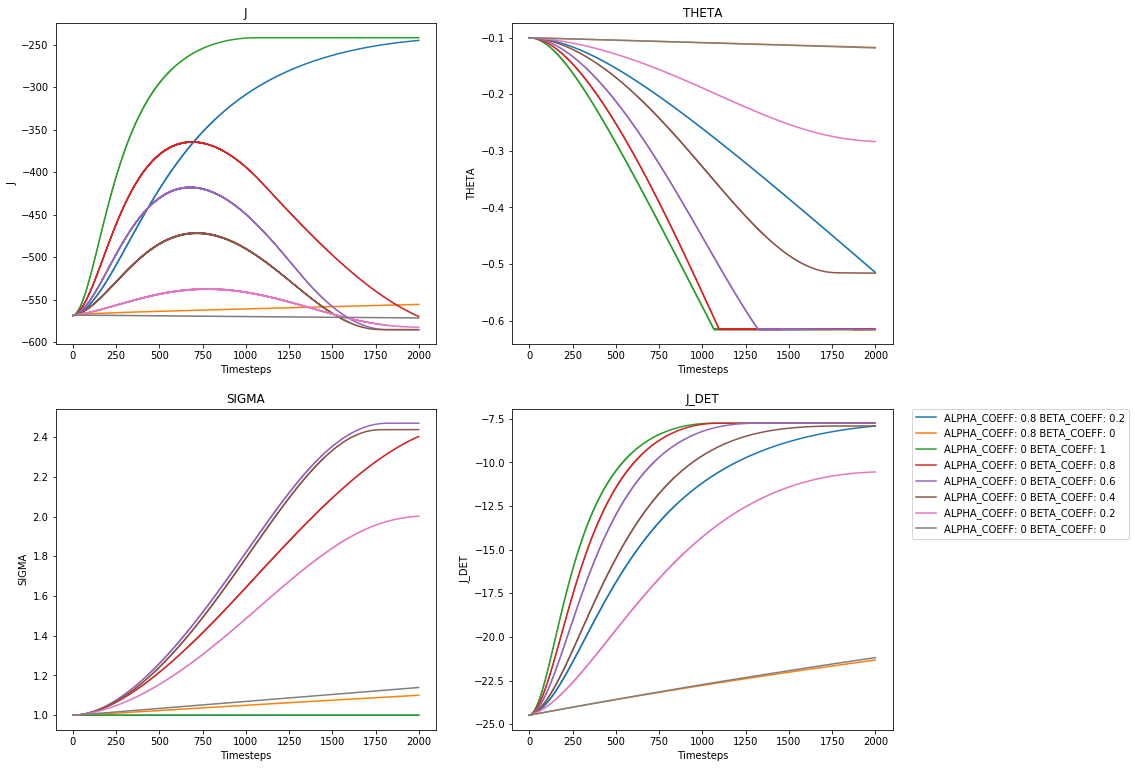

In [166]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        alpha_coeff = ['0', '0.8'],
        beta_coeff = None,
        experiment='ExpThetaAndSigmaBudget',
        gamma_coeff='-',
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'J_DET'], 
        min_t = 0,
        max_t=2000,
        df = experiments_df)

## Alternating budgets

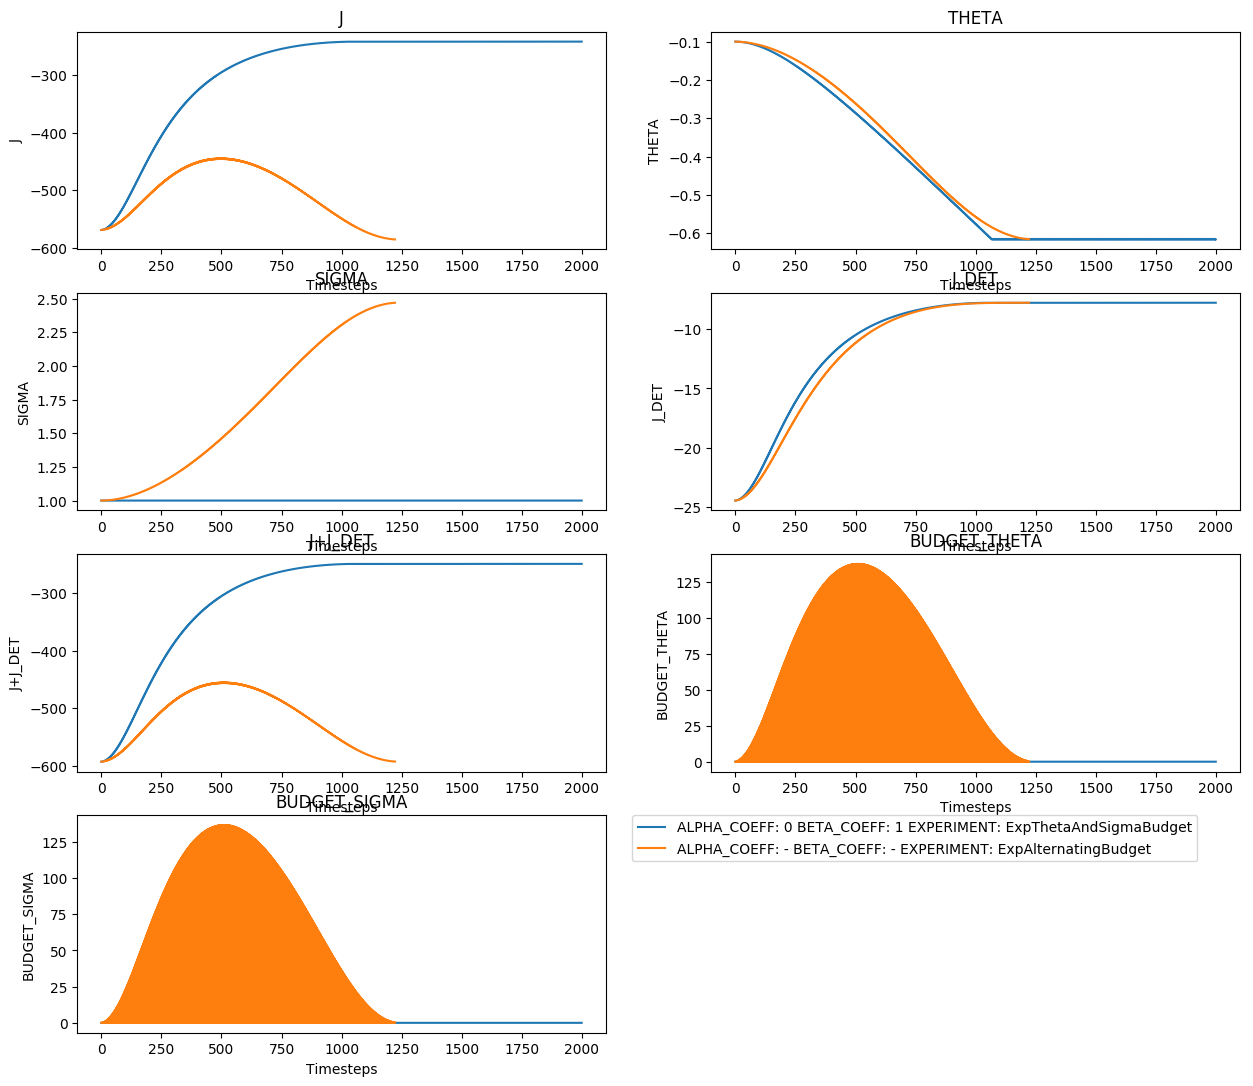

In [28]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        alpha_coeff = ['-', '0'],
        beta_coeff = ['-', '1'],
        experiment=['ExpAlternatingBudget', 'ExpThetaAndSigmaBudget'],
        gamma_coeff='-',
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'J_DET', 'J+J_DET', 'BUDGET_THETA', 'BUDGET_SIGMA'], 
        min_t = 0,
        max_t=2000,
        df = experiments_df)

## Exp Single Budget

### Behaviour changing starting sigma value

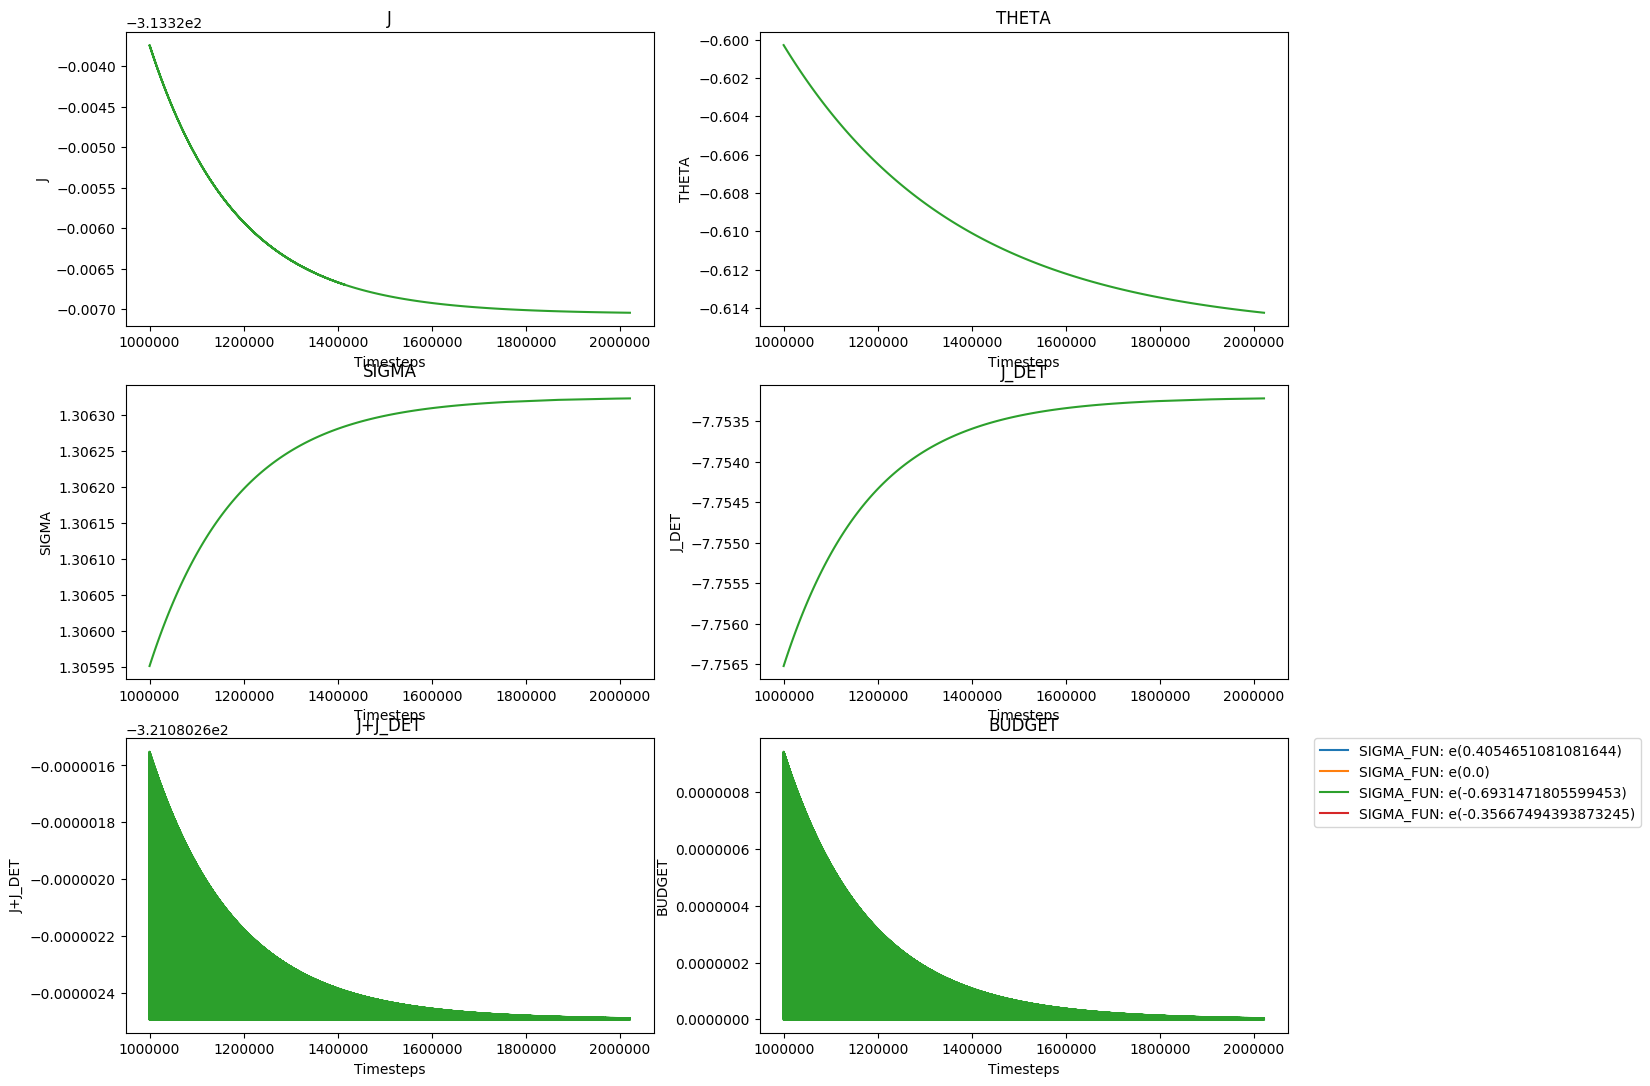

In [76]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment='ExpSingleBudget',
        gamma_coeff='-',
        sigma_fun=None,
        value=['J', 'THETA', 'SIGMA', 'J_DET', 'J+J_DET', 'BUDGET'], 
        min_t = 200000,
        max_t=-1,
        df = experiments_df)

### Confronto con dare tutto il budget a theta

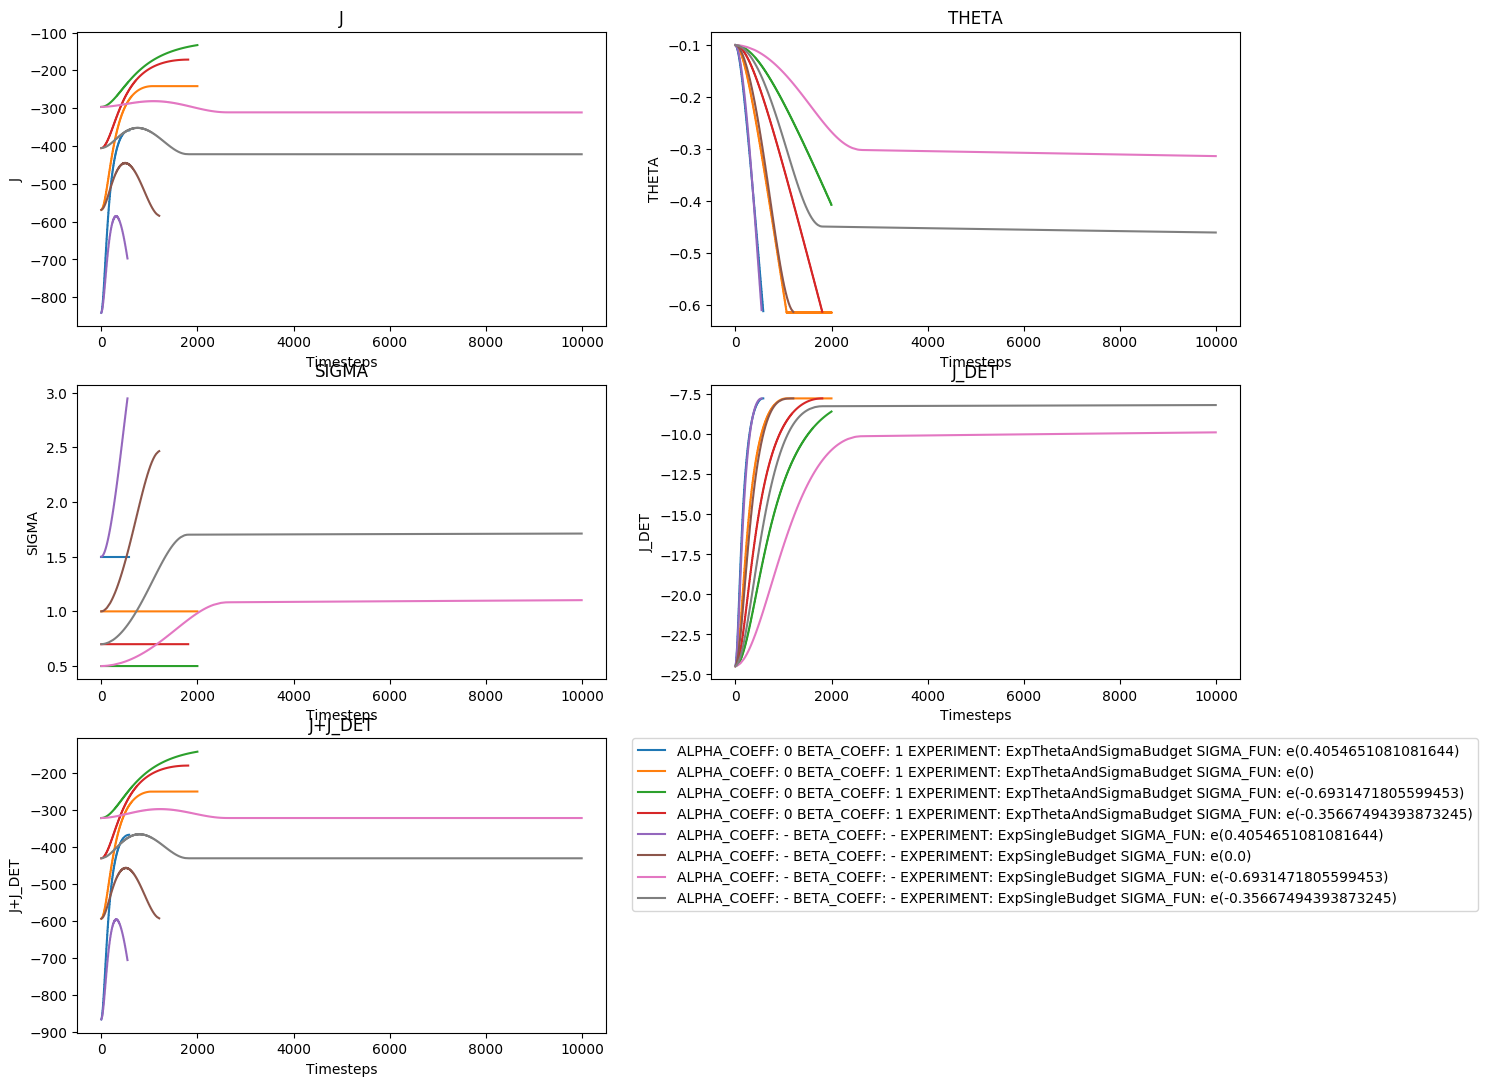

In [47]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        alpha_coeff=['-', '0'],
        beta_coeff = ['-', '1'],
        experiment=['ExpSingleBudget', 'ExpThetaAndSigmaBudget'],
        gamma_coeff='-',
        sigma_fun=None,
        value=['J', 'THETA', 'SIGMA', 'J_DET', 'J+J_DET'], 
        min_t = 0,
        max_t=2000,
        df = experiments_df)

## Exp discounted single budget

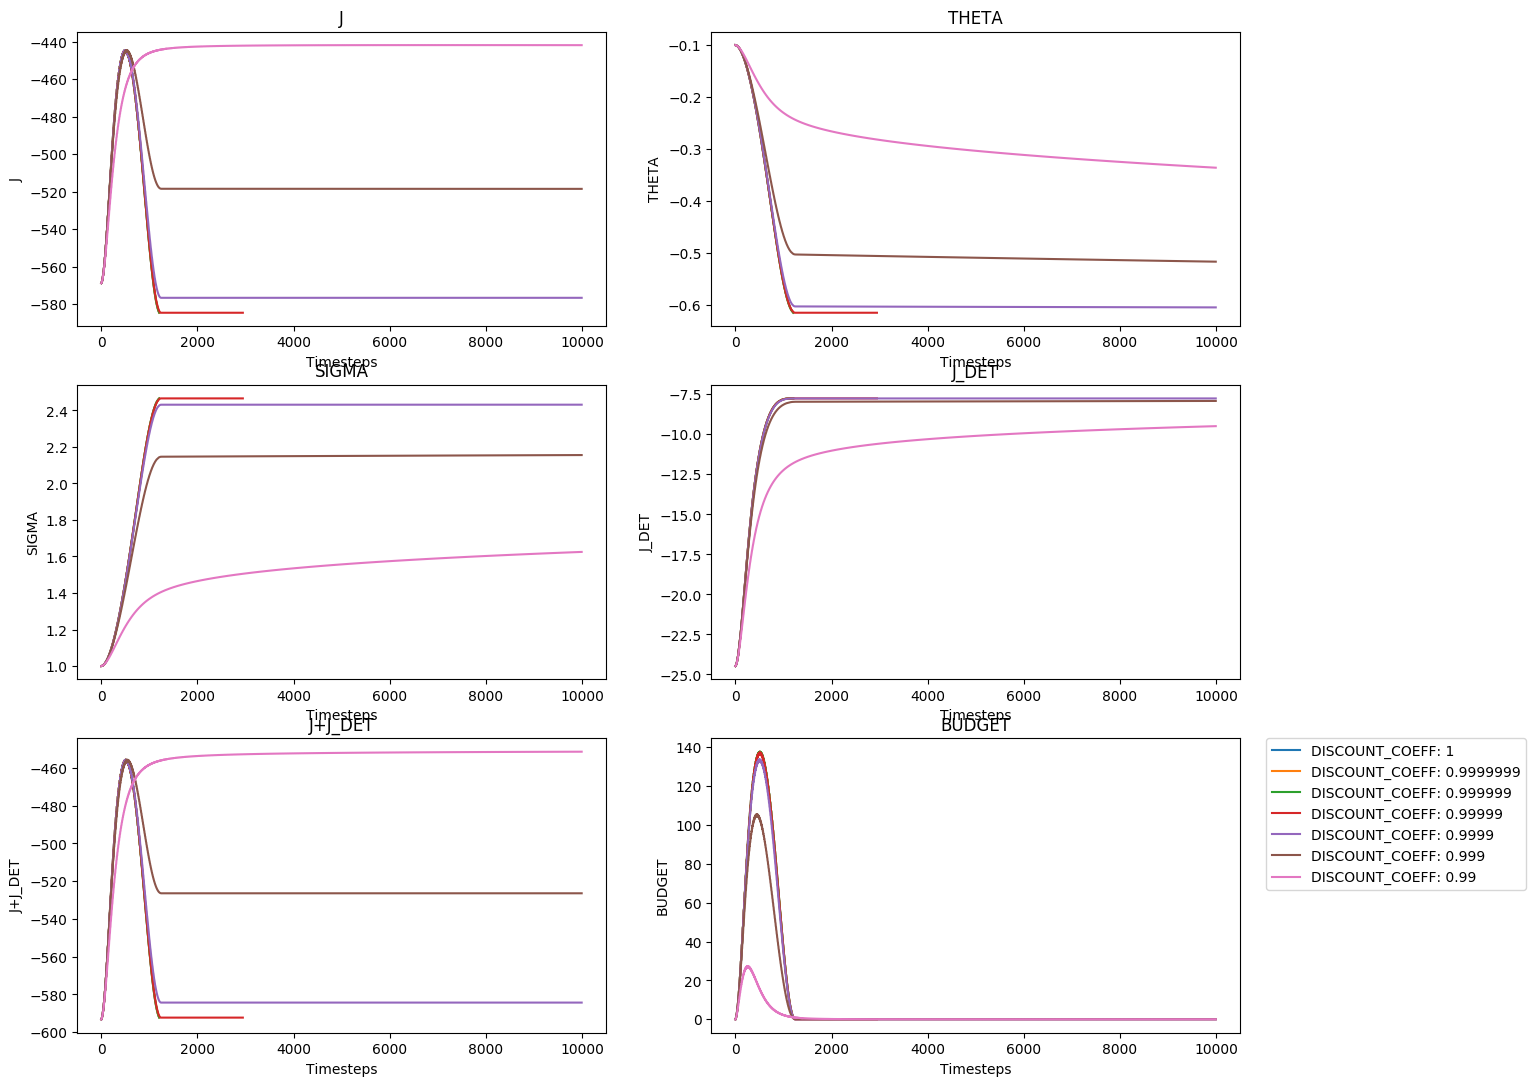

In [60]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment='ExpDiscountedSingleBudget',
        gamma_coeff='-',
        sigma_fun='e(0)',
        discount_coeff=None,
        value=['J', 'THETA', 'SIGMA', 'J_DET', 'J+J_DET', 'BUDGET'], 
        min_t = 0,
        max_t=2000,
        df = experiments_df)

## Exp single budget with random baselines

In [64]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment='ExpSingleBudgetRandomBaselines',
        gamma_coeff='-',
        sigma_fun='e(0)',
        baseline_prob=None,
        value=['J', 'THETA', 'SIGMA', 'J_DET', 'J+J_DET', 'BUDGET'], 
        min_t = 0,
        max_t=10000,
        df = experiments_df)

# Non exact environment

In [58]:
#BASE_FOLDER = 'experiments_non_exact'
BASE_FOLDER = 'experiments_safe/'

exp_df = load_dataframe(BASE_FOLDER)

In [59]:
exp_df

DELTA                   EXPERIMENT                          FILENAME GAMMA  \
0   0.1  SafeExperimentSemiDetPolicy  experiments_safe/odjKP9FEYWFtxMI  0.99   
1   0.1  SafeExperimentSemiDetPolicy  experiments_safe/SrExaCWJiYv8N73  0.99   
2   0.1            SafeSemiDetPolicy  experiments_safe/cqVQbJs6S8SPnKj  0.99   
3   0.1            SafeSemiDetPolicy  experiments_safe/lGHg0oNGHBqJYkR  0.99   
4   0.1  SafeExperimentSemiDetPolicy  experiments_safe/1D8MQA7Bfk6t8cY  0.99   
5   0.1  SafeExperimentSemiDetPolicy  experiments_safe/speedsaCH21Tmme  0.99   
6   0.1                      NonSafe  experiments_safe/5QwkUXV9G2WHMBg  0.99   
7   0.1  SafeExperimentSemiDetPolicy  experiments_safe/yp9V9qv4p9szDjS  0.99   

  MAX_ITER                   NAME   N_MAX N_MIN     N_TOT PARALLEL  \
0     5000  SafeDeterministic_0.1  500000   450  30000000     True   
1     5000        SafeSemiDet_0.3  500000   450  30000000     True   
2     5000      SafeSemiDetPolicy  500000   450  30000000     True   
3     5000      SafeSemiDetPolicy  500000   450  30000000     True   
4     5000  SafeDeterministic_0.5  500000   450  30000000     True   
5     5000        SafeSemiDet_0.5  500000   450  30000000     True   
6     5000                NonSafe  500000   450  30000000     True   
7     5000        SafeSemiDet_0.1  500000   450  30000000     True   

  USE_LOCAL_STATS VERBOSE  
0            True    True  
1            True    True  
2            True    True  
3            True    True  
4            True    True  
5            True    True  
6            True    True  
7            True    True

Initial J+J_DET is:  -91.71327111431846
Average J+J_DET is:  -72.73450220498044
Budget is negative for:  3180 / 15000  times


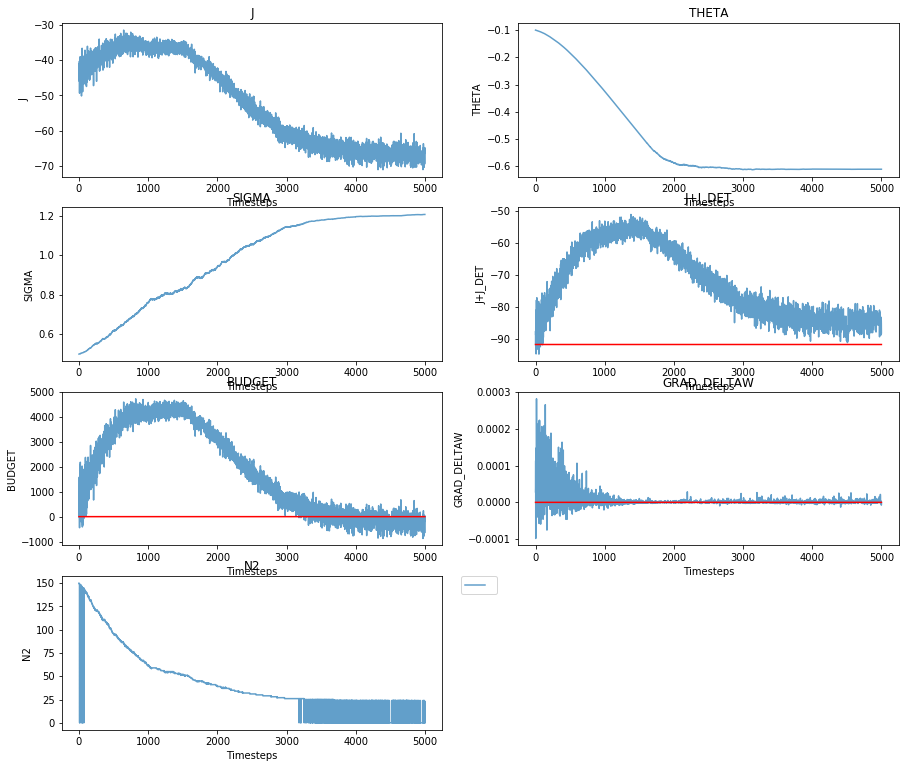

In [60]:
my_plot(value=['J', 'THETA', 'SIGMA', 'J+J_DET', 'BUDGET', 'GRAD_DELTAW', 'N2'], 
        min_t = 0,
        max_t=-1,
        name = 'SafeDeterministic_0.5',
        experiment='SafeExperimentSemiDetPolicy',
        step=3,
        alpha=0.7,
        df = exp_df)

Initial J+J_DET is:  -174.5088567709442
Average J+J_DET is:  -111.36690346808692
Initial J+J_DET is:  -167.6888964726513
Average J+J_DET is:  -95.76918672563592
Initial J+J_DET is:  -173.11180331410594
Average J+J_DET is:  -168.30692520752044
Budget is negative for:  1779 / 15000  times
Budget is negative for:  6187 / 15000  times
Budget is negative for:  7183 / 15000  times


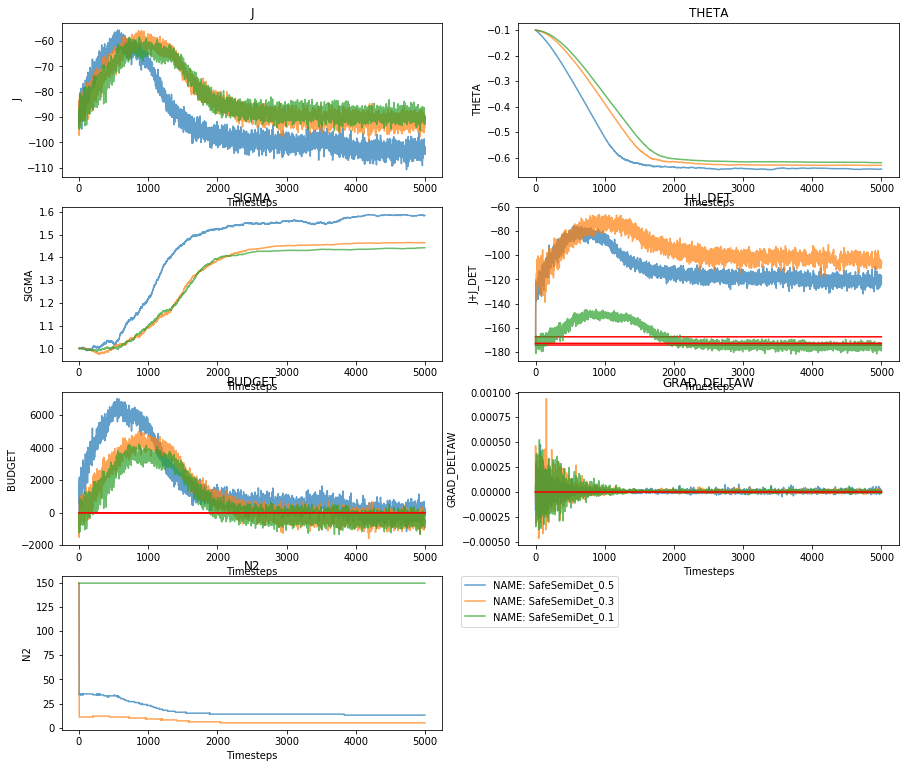

In [53]:
my_plot(value=['J', 'THETA', 'SIGMA', 'J+J_DET', 'BUDGET', 'GRAD_DELTAW', 'N2'], 
        min_t = 0,
        max_t=-1,
        name = None,
        experiment='SafeExperimentSemiDetPolicy',
        step=3,
        alpha=0.7,
        df = exp_df)

In [20]:
my_plot(value=['GRAD_THETA', 'GRAD_W', 'GRAD_MIXED', 'GRAD_DELTAW'], 
        min_t = 0,
        max_t=-1,
        n_min=None,
        name = 'Exp_parallel500',
        max_iter = '3000',
        df = exp_df)

In [114]:
BASE_FOLDER = 'experiments_safe'

exp_df2 = load_dataframe(BASE_FOLDER)

In [117]:
exp_df = pd.concat([exp_df, exp_df2])

In [119]:
exp_df

DELTA                   EXPERIMENT  \
0   0.1  SafeExperimentSemiDetPolicy   
0   0.1  SafeExperimentSemiDetPolicy   
1   0.1  SafeExperimentSemiDetPolicy   
2   0.1            SafeSemiDetPolicy   
3   0.1            SafeSemiDetPolicy   
4   0.1  SafeExperimentSemiDetPolicy   
5   0.1  SafeExperimentSemiDetPolicy   
6   0.1                      NonSafe   
7   0.1  SafeExperimentSemiDetPolicy   

                                        FILENAME GAMMA MAX_ITER  \
0  experiments_non_deterministic/tfcQN1IsABfGQBt  0.99     2000   
0               experiments_safe/odjKP9FEYWFtxMI  0.99     5000   
1               experiments_safe/SrExaCWJiYv8N73  0.99     5000   
2               experiments_safe/cqVQbJs6S8SPnKj  0.99     5000   
3               experiments_safe/lGHg0oNGHBqJYkR  0.99     5000   
4               experiments_safe/1D8MQA7Bfk6t8cY  0.99     5000   
5               experiments_safe/speedsaCH21Tmme  0.99     5000   
6               experiments_safe/5QwkUXV9G2WHMBg  0.99     5000   
7               experiments_safe/yp9V9qv4p9szDjS  0.99     5000   

                    NAME   N_MAX N_MIN     N_TOT PARALLEL USE_LOCAL_STATS  \
0          ProvaBaseline  500000   450  30000000     True            True   
0  SafeDeterministic_0.1  500000   450  30000000     True            True   
1        SafeSemiDet_0.3  500000   450  30000000     True            True   
2      SafeSemiDetPolicy  500000   450  30000000     True            True   
3      SafeSemiDetPolicy  500000   450  30000000     True            True   
4  SafeDeterministic_0.5  500000   450  30000000     True            True   
5        SafeSemiDet_0.5  500000   450  30000000     True            True   
6                NonSafe  500000   450  30000000     True            True   
7        SafeSemiDet_0.1  500000   450  30000000     True            True   

  VERBOSE  
0    True  
0    True  
1    True  
2    True  
3    True  
4    True  
5    True  
6    True  
7    True

In [71]:
BASE_FOLDER = 'experiments_non_deterministic'

exp_df = load_dataframe(BASE_FOLDER)

In [72]:
exp_df

DELTA                   EXPERIMENT  \
0   0.1  SafeExperimentSemiDetPolicy   

                                        FILENAME GAMMA MAX_ITER  \
0  experiments_non_deterministic/tfcQN1IsABfGQBt  0.99     2000   

            NAME   N_MAX N_MIN     N_TOT PARALLEL USE_LOCAL_STATS VERBOSE  
0  ProvaBaseline  500000   450  30000000     True            True    True

In [75]:
data = load_from_dataframe(exp_df)

In [77]:
data = data[0]

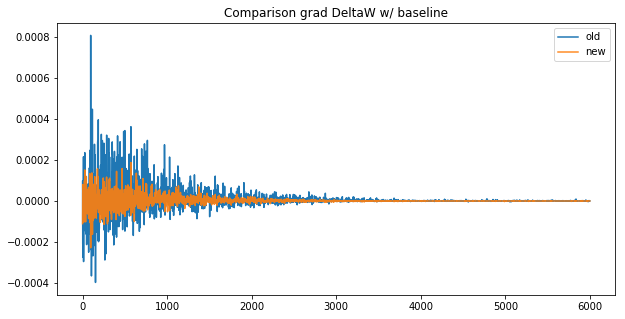

In [101]:
plt.figure(figsize=(10, 5))
plt.title("Comparison grad DeltaW w/ baseline")
plt.plot(data['T'], data['GRAD_DELTAW_OLD'], alpha=1)
plt.plot(data['T'], data['GRAD_DELTAW'], alpha=0.9)

plt.legend(['old', 'new'])

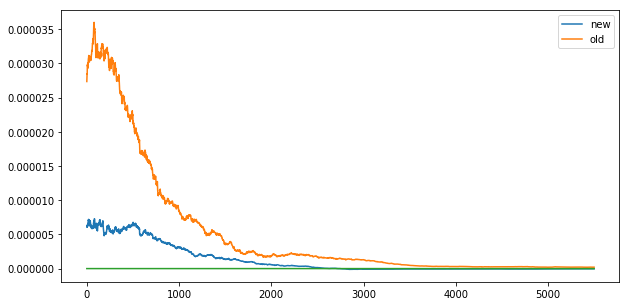

In [109]:
N = 500
plt.figure(figsize=(10, 5))
plt.plot(data['T'][:-N+1], np.convolve(data['GRAD_DELTAW'], np.ones((N,))/N, mode='valid'))
plt.plot(data['T'][:-N+1], np.convolve(data['GRAD_DELTAW_OLD'], np.ones((N,))/N, mode='valid'))
plt.legend(['new', 'old'])
plt.plot(data['T'][:-N+1], [0]*data['T'][:-N+1])

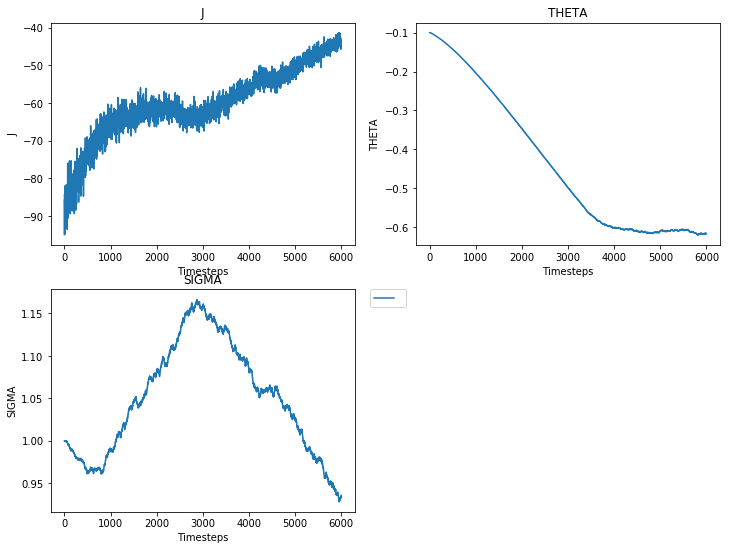

In [108]:
plt.figure(figsize=(12,9))
my_plot(value=['J', 'THETA', 'SIGMA'], 
        min_t = 0,
        max_t=-1,
        alpha=1,
        df = exp_df)

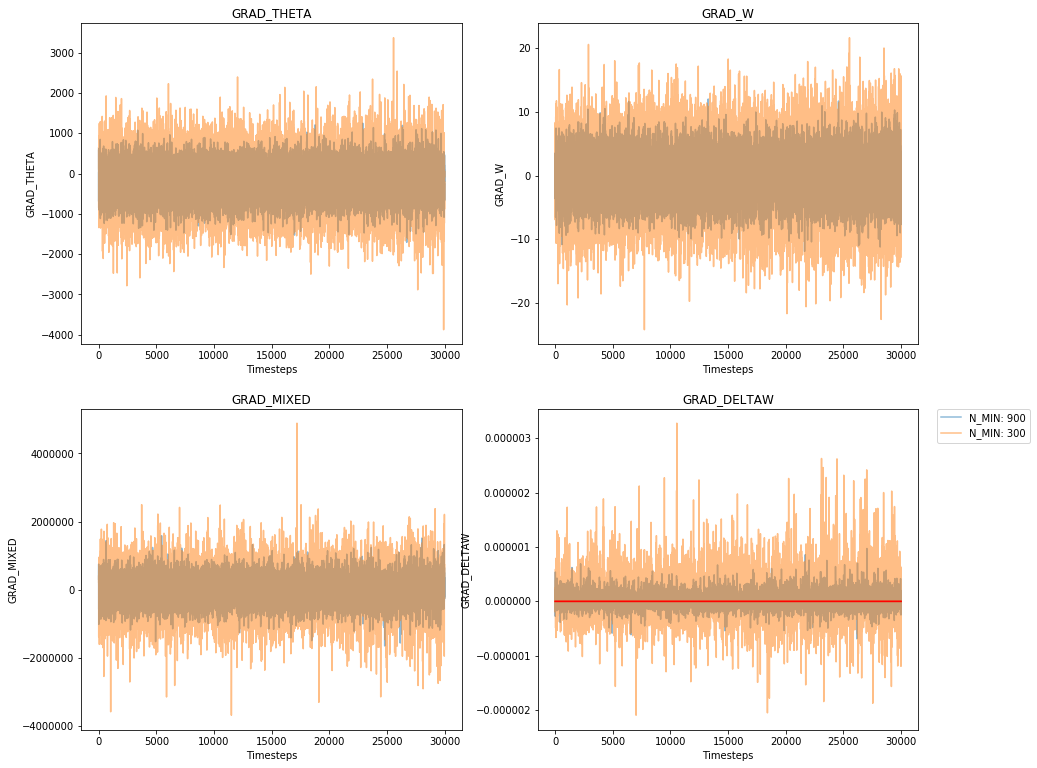

In [68]:
my_plot(value=['GRAD_THETA', 'GRAD_W', 'GRAD_MIXED', 'GRAD_DELTAW'], 
        min_t = 0,
        max_t=-1,
        n_min=['300', '900'],
        name = 'Safe',
        alpha=0.5,
        df = exp_df)

# Parallel vs serial trajectories

In [57]:
BASE_FOLDER = 'experiments_parallel_vs_serial/'

new_df = load_dataframe(BASE_FOLDER)

In [135]:
new_df = new_df.loc[(2, 3),:]

Initial J+J_DET is:  -111.64261989266225
Average J+J_DET is:  -77.6732279676491
Initial J+J_DET is:  -114.53020507924826
Average J+J_DET is:  -95.67182584361761
Budget is negative for:  93 / 4500  times
Budget is negative for:  441 / 4500  times


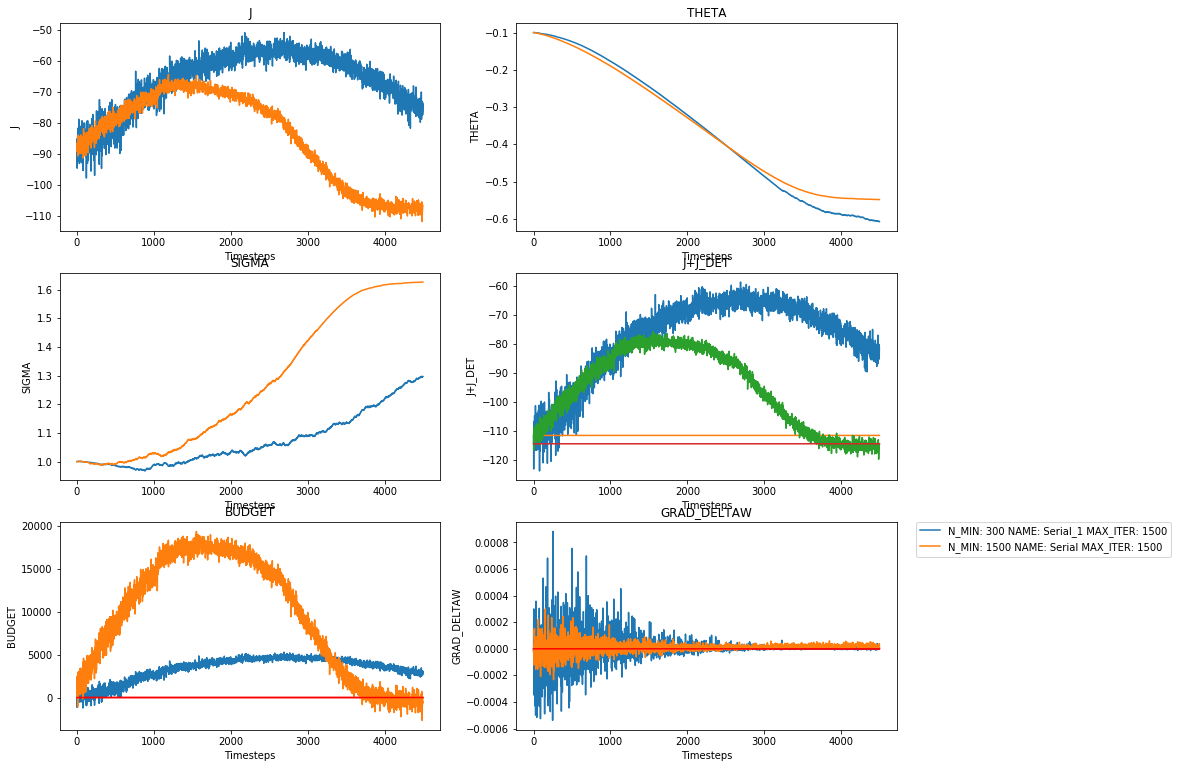

In [143]:
my_plot(value=['J', 'THETA', 'SIGMA', 'J+J_DET', 'BUDGET', 'GRAD_DELTAW'], 
        min_t = 0,
        max_t=-1,
        n_min=None,
        name = None,
        max_iter = None,
        df = new_df)

In [88]:
BASE_FOLDER = 'Experiments parallel/'

new_df = load_dataframe(BASE_FOLDER)

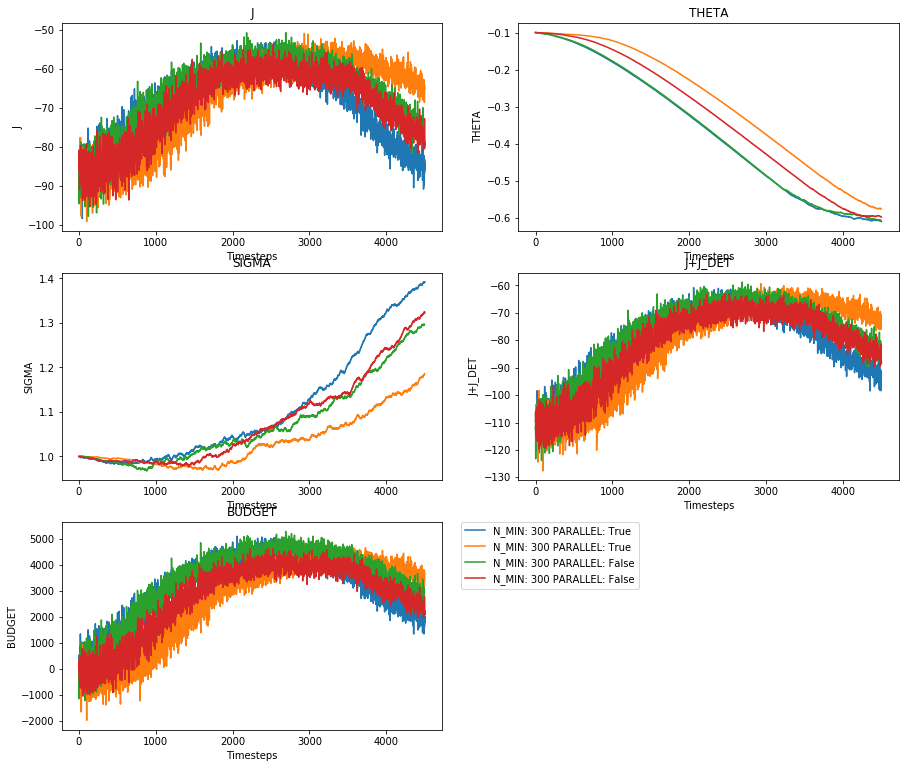

In [90]:
my_plot(value=['J', 'THETA', 'SIGMA', 'J+J_DET', 'BUDGET'], 
        min_t = 0,
        max_t=-1,
        n_min=None,
        name = 'Serial_1',
        parallel=None,
        df = new_df)

# Experiments

In [71]:
experiments_df_2 = load_dataframe('exploration_cost_exp')

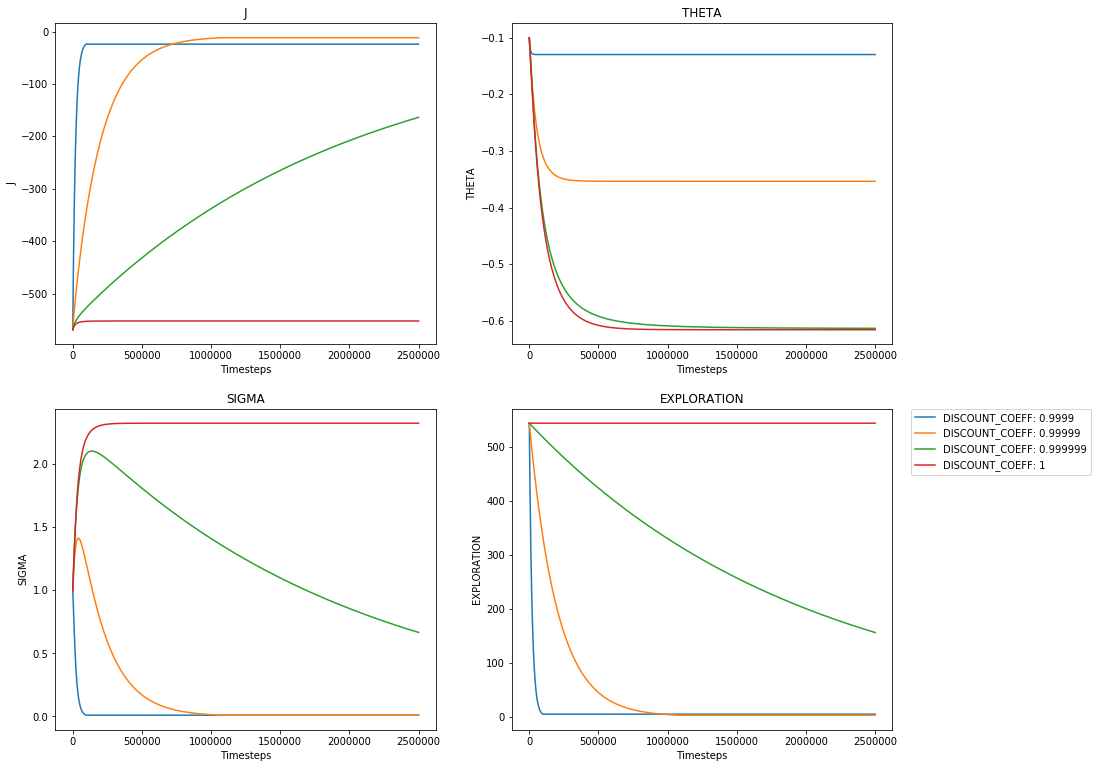

In [42]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment='ExpExplorationCost_two_steps',
        gamma_coeff='-',
        discount_coeff=None,
        init_exp = '-1',
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'EXPLORATION'], 
        max_t=-1,
        df = experiments_df_2)

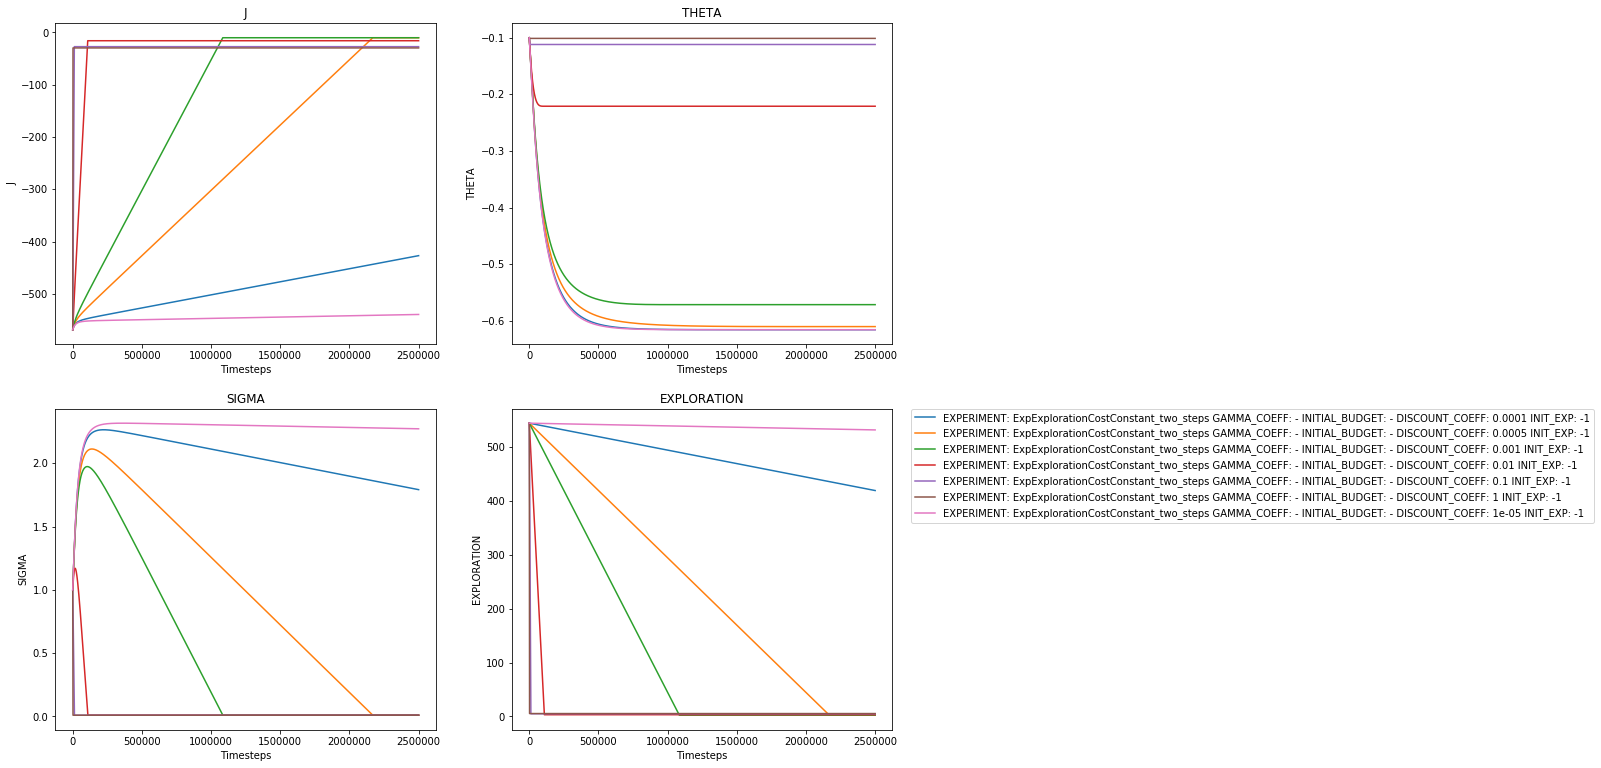

In [72]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment=['ExpExplorationCostConstant_two_steps'],
        gamma_coeff=None,
        initial_budget=None,
        discount_coeff=None,
        init_exp = None,
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'EXPLORATION'], 
        max_t=-1,
        df = experiments_df_2)

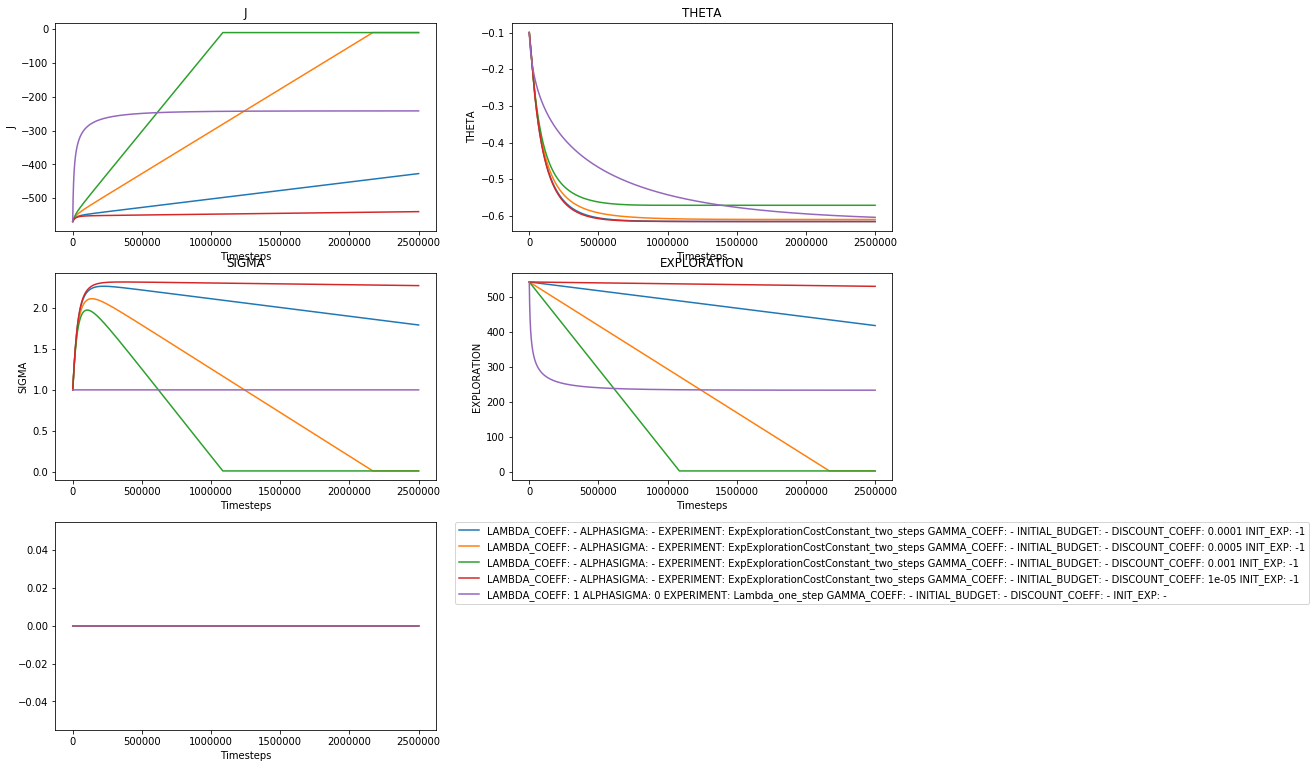

In [80]:
my_plot(lambda_coeff = ['-', '1'], 
        theta='-0.1', 
        alphaSigma = ['-', '0'] ,
        experiment=['ExpExplorationCostConstant_two_steps', 'Lambda_one_step'],
        gamma_coeff=None,
        initial_budget=None,
        discount_coeff=['0.0001', '0.0005', '0.001', '1e-05', '-'],
        init_exp = None,
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'EXPLORATION', ''], 
        max_t=-1,
        df = pd.concat([experiments_df_2, experiments_df]).fillna('-'))

# Comparison between budget and exploration

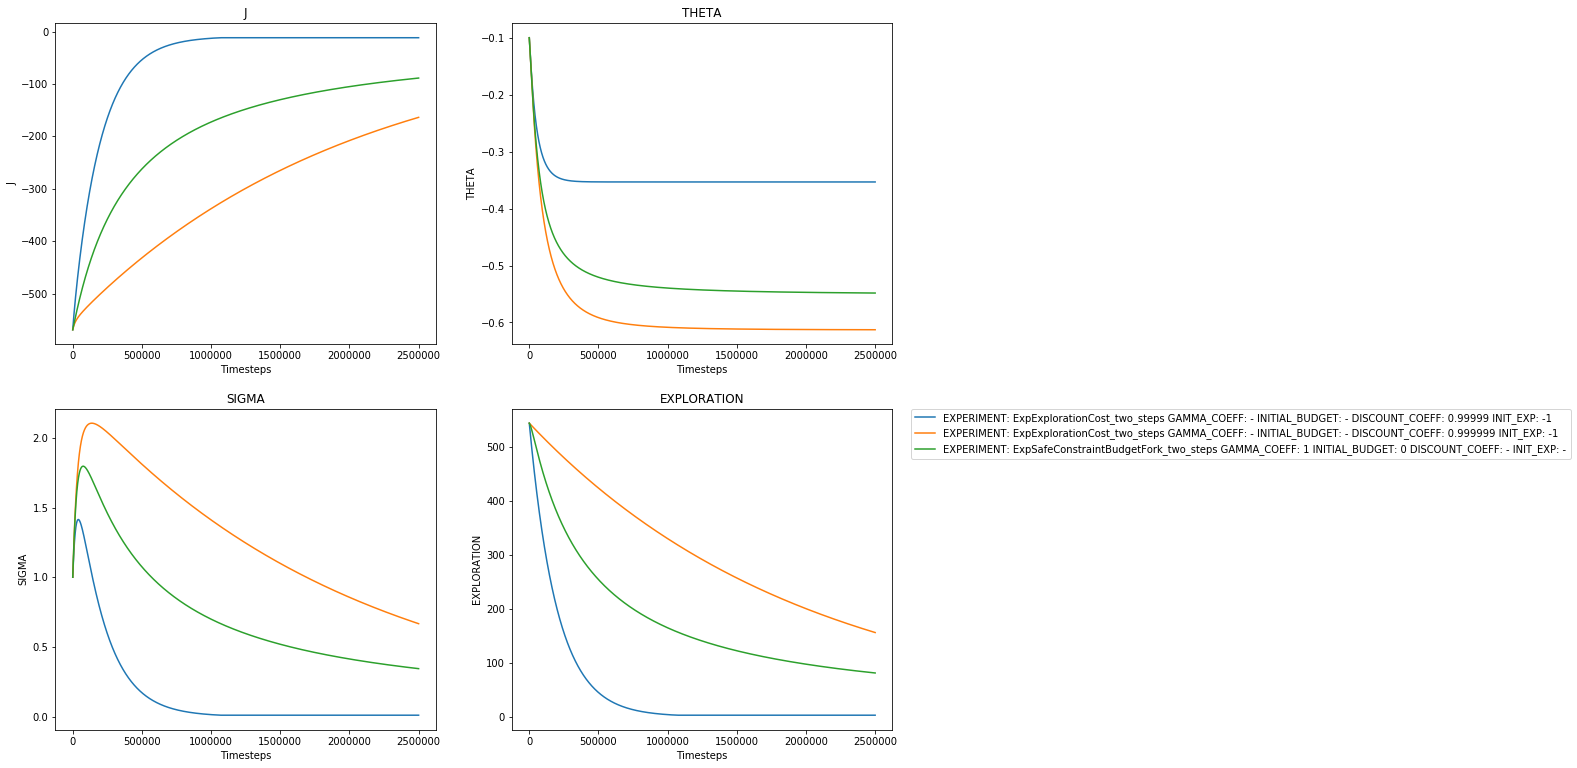

In [59]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment=['ExpSafeConstraintBudgetFork_two_steps','ExpExplorationCost_two_steps'],
        gamma_coeff=['-', '1'],
        initial_budget=['-', '0'],
        discount_coeff=['-', '0.99999', '0.999999'],
        init_exp = ['-', '-1'],
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'EXPLORATION'], 
        max_t=-1,
        df = experiments_df_2)

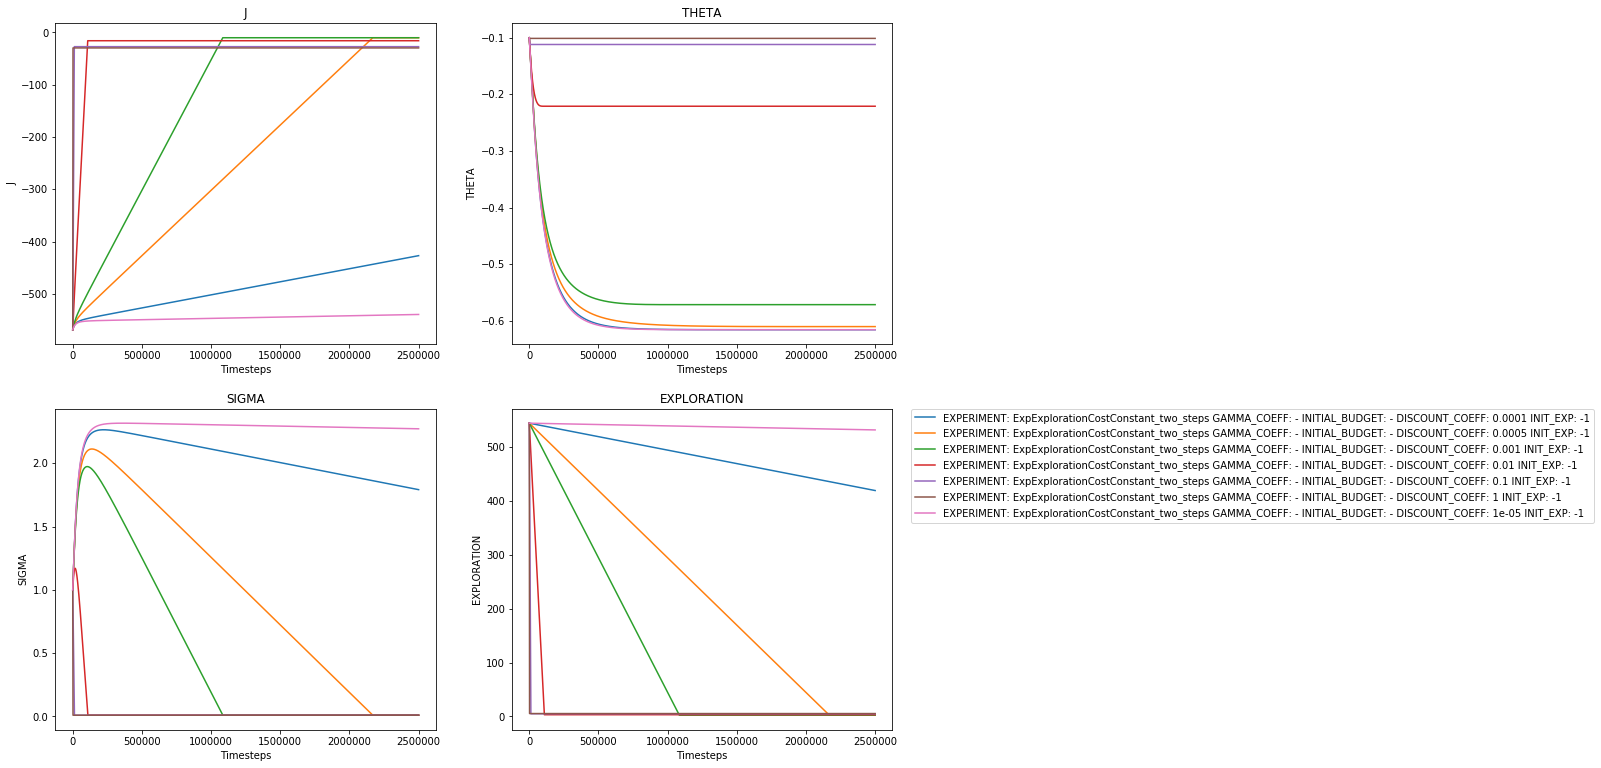

In [69]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment=['ExpExplorationCostConstant_two_steps'],
        gamma_coeff=None,
        initial_budget=None,
        discount_coeff=None,
        init_exp = None,
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'EXPLORATION'], 
        max_t=-1,
        df = asdf)

In [73]:
prova_df = load_dataframe('prova/')

In [74]:
asdf = pd.concat([prova_df, load_dataframe('prova2/')]).fillna('-')

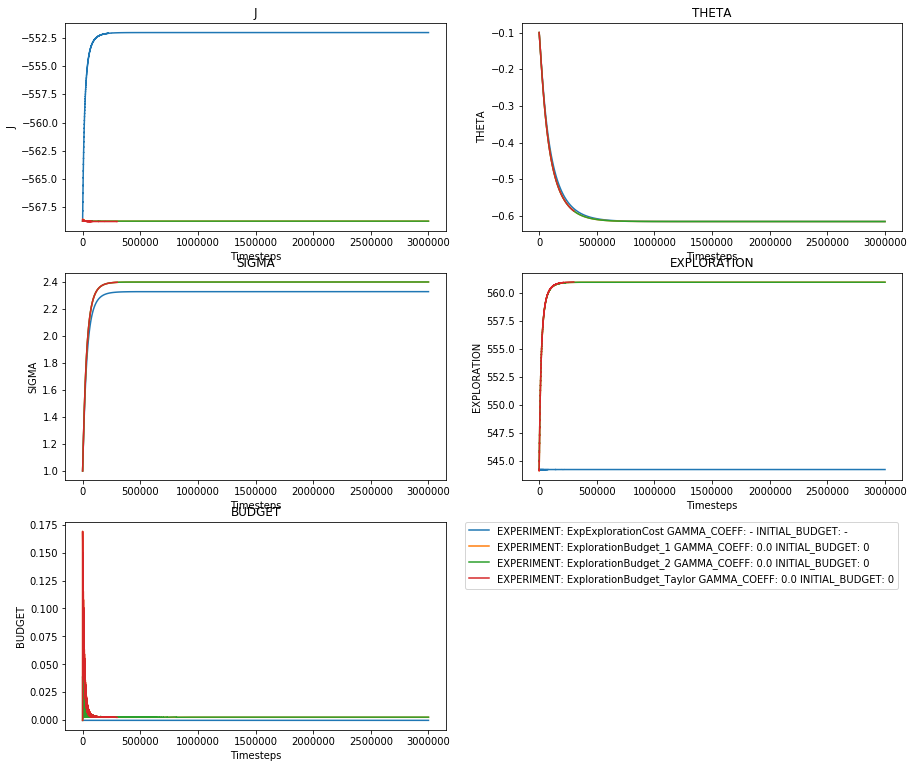

In [75]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment=None,
        gamma_coeff=None,
        initial_budget=None,
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'EXPLORATION', 'BUDGET'], 
        max_t=-1,
        df = asdf)

In [104]:
prova_df = load_dataframe('prova2/')

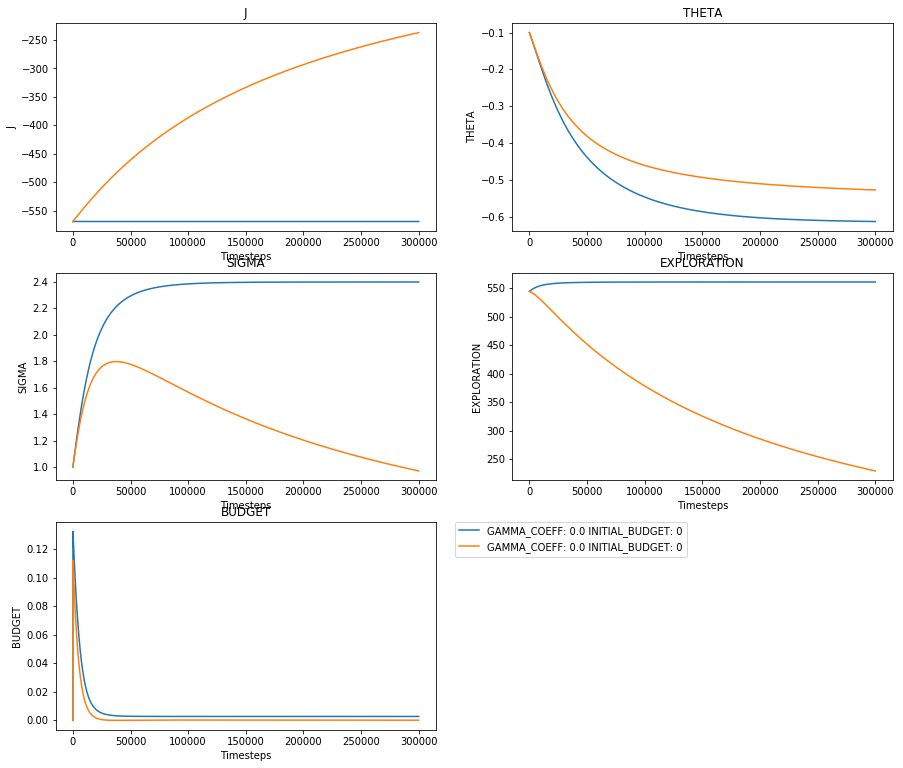

In [105]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment='ExpSafeConstraintBudgetFork',
        gamma_coeff=None,
        initial_budget=None,
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'EXPLORATION', 'BUDGET'], 
        max_t=-1,
        df = prova_df)

In [29]:
lqg = lqg1d.LQG1D()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [30]:
lqg.gamma

0.99

In [110]:
lqg.grad_K(-0.2, 1.5)

-1547.764392364752

In [111]:
lqg.grad_K(-0.2, 0)

-53.6603039606415

In [113]:
lqg.grad_Sigma(-0.2, 1.5)

-342.9039301310041

In [121]:
import utils
import math
sigma= 1
d = utils.computeLossSigma(lqg.Q * (lqg.max_pos)**2 + lqg.R * lqg.max_action**2, lqg.max_pos, lqg.gamma, 2*lqg.max_action, sigma)

In [122]:
d

array([[29115137.68741015]])

In [123]:
gradW = lqg.grad_Sigma(-0.1, sigma) * math.exp(sigma)

In [124]:
gradW**2 / (4*d)

array([[0.01879489]])

In [150]:
param=1

In [151]:
lqg.grad_Sigma(-0.2, math.exp(param)) * math.exp(param)

-932.1095221822984

In [112]:
lqg.computeJ(-0.1, 1)

-568.74305906108

In [113]:
lqg.computeJ(-0.101, 1)

-564.5717159423998

In [108]:
lqg.computeJ(-0.1, 0)

-24.472488642099957

In [109]:
lqg.computeJ(-0.101, 0)

-24.259257044978924

In [116]:
lqg.computeJ(-0.2, 0) - lqg.computeJ(-0.2, 1.5)

514.3558951965061

In [178]:
THETA = -0.2
SIGMA = 0.7

step_theta = -1e-10
step_sigma = 1e-10

alpha_sigma = step_sigma / lqg.grad_Sigma(THETA, SIGMA)
alpha_theta = step_theta / lqg.grad_K(THETA, SIGMA)

In [179]:
exp_cost = lqg.computeJ(THETA, 0) - lqg.computeJ(THETA, SIGMA)

In [180]:
exp_cost_after = lqg.computeJ(THETA + step_theta, 0) - lqg.computeJ(THETA + step_theta, SIGMA + step_sigma)

In [181]:
exp_cost - exp_cost_after

3.543448201526189e-08

In [182]:
estimation = -alpha_theta * (lqg.grad_K(THETA, 0))**2 + alpha_theta * (lqg.grad_K(THETA, SIGMA))**2 + alpha_sigma * (lqg.grad_Sigma(THETA, SIGMA))**2
estimation

4.0417035769303134e-08

In [318]:
BASE_FOLDER = 'prova'

p = load_dataframe(BASE_FOLDER)

In [270]:
d = filter_experiments(df=p, name=['ProvaSafe', 'ProvaSafe_update_dopo', 'ProvaSafe_update_dopo_dopo'])

In [254]:
d = filter_experiments(df=p, name=['ProvaGradienti7', 'ProvaGradienti8'])

Budget is negative for:  218 / 2000  times
Budget is negative for:  234 / 2000  times


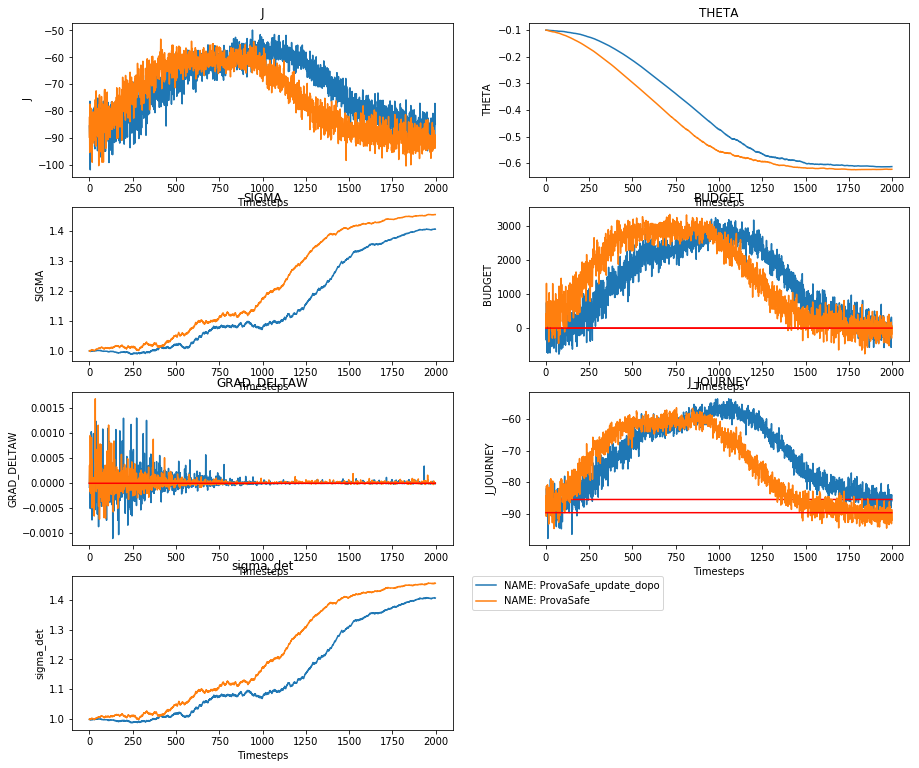

In [320]:
my_plot(value=['J', 'THETA', 'SIGMA', 'BUDGET', 'GRAD_DELTAW', 'J_JOURNEY', 'sigma_det'], 
        min_t = 0,
        max_t=-1,
        name = ['ProvaSafe', 'ProvaSafe_update_dopo'],
        step=1,
        alpha=1,
        df = p)

# Confronto gradienti

In [306]:
BASE_FOLDER = 'prova'

p = load_dataframe(BASE_FOLDER)

d = filter_experiments(df=p, name='ProvaGradienti8')

In [307]:
data = load_from_dataframe(d)[0]

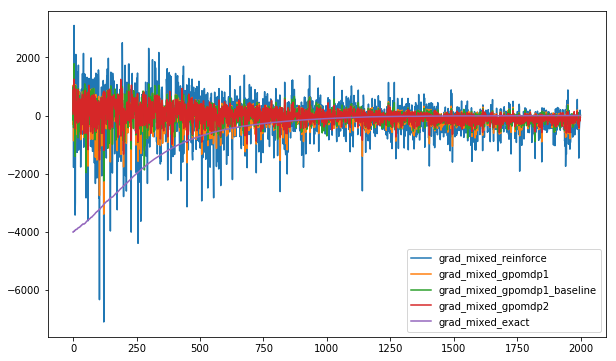

In [308]:
plt.figure(figsize=(10,6))
plt.plot(data['T'], data['grad_mixed_reinforce'])
plt.plot(data['T'], data['grad_mixed_gpomdp1'])
plt.plot(data['T'], data['grad_mixed_gpomdp1_baseline'])
plt.plot(data['T'], data['grad_mixed_gpomdp2'])
plt.plot(data['T'], data['grad_mixed_exact'])

plt.legend(['grad_mixed_reinforce', 'grad_mixed_gpomdp1', 'grad_mixed_gpomdp1_baseline', 'grad_mixed_gpomdp2', 'grad_mixed_exact'])

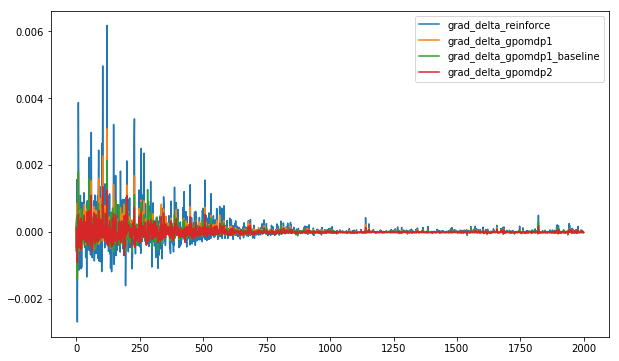

In [309]:
plt.figure(figsize=(10,6))
plt.plot(data['T'], data['grad_delta_reinforce'])
plt.plot(data['T'], data['grad_delta_gpomdp1'])
plt.plot(data['T'], data['grad_delta_gpomdp1_baseline'])
plt.plot(data['T'], data['grad_delta_gpomdp2'])
#plt.plot(data['T'], data['grad_delta_exact'])
plt.legend(['grad_delta_reinforce', 'grad_delta_gpomdp1', 'grad_delta_gpomdp1_baseline', 'grad_delta_gpomdp2', 'grad_delta_exact'])



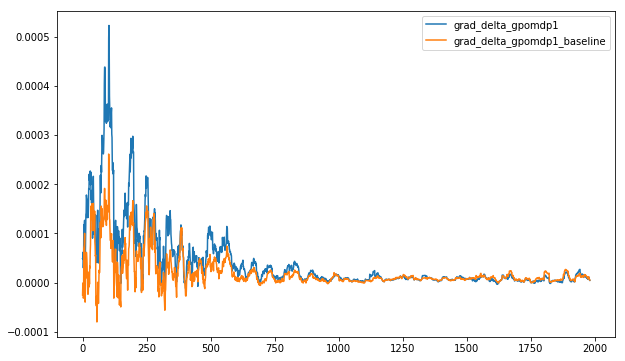

In [313]:
N=20
plt.figure(figsize=(10,6))
#plt.plot(data['T'][:-N+1], np.convolve(data['grad_delta_reinforce'], np.ones((N,))/N, mode='valid'))
plt.plot(data['T'][:-N+1], np.convolve(data['grad_delta_gpomdp1'], np.ones((N,))/N, mode='valid'))
plt.plot(data['T'][:-N+1], np.convolve(data['grad_delta_gpomdp1_baseline'], np.ones((N,))/N, mode='valid'))
#plt.plot(data['T'][:-N+1], np.convolve(data['grad_delta_gpomdp2'], np.ones((N,))/N, mode='valid'))
#plt.plot(data['T'][:-N+1], np.clip(data['grad_delta_exact'][:-N+1], -0.0002, 0.00040))
#plt.legend(['grad_delta_reinforce', 'grad_delta_gpomdp1', 'grad_delta_gpomdp1_baseline', 'grad_delta_gpomdp2', 'grad_delta_exact'])

plt.legend(['grad_delta_gpomdp1', 'grad_delta_gpomdp1_baseline', 'grad_delta_gpomdp2', 'grad_delta_exact'])


In [314]:
print('Standard deviation of plain estimator: ', np.std(data['grad_delta_gpomdp1']))

Standard deviation of plain estimator:  0.00019891408765592957


In [315]:
print('Standard deviation with baseline: ', np.std(data['grad_delta_gpomdp1_baseline']))

Standard deviation with baseline:  0.0001574311015838082


In [321]:
p

DELTA             EXPERIMENT               FILENAME GAMMA MAX_ITER  \
0    0.1             Experiment  prova/PxU5RAQ3gGvu9XV  0.99      200   
1    0.1             Experiment  prova/jG08pl4TnCvxIO7  0.99       50   
2    0.1             Experiment  prova/6pUV7RfITQtP41B  0.99       50   
3    0.1  CollectDataExperiment  prova/PuLH7J5hacNTru0  0.99      500   
4    0.1  CollectDataExperiment  prova/o6wnDXgySnwi8LZ  0.99     1000   
5    0.1  CollectDataExperiment  prova/Xn9nWgTKUi4hQep  0.99     1000   
6    0.1             Experiment  prova/KdrB3UiQRyfuRW2  0.99       50   
7    0.1  CollectDataExperiment  prova/04XRbDCKrpQLdmj  0.99     2000   
8    0.1         SafeExperiment  prova/AcI6LhpGlOfW4xt  0.99     2000   
9    0.1  CollectDataExperiment  prova/NAjdAIkKz7Sv74m  0.99     1000   
10   0.1             Experiment  prova/s9dZk551eqbsYki  0.99       50   
11   0.1  CollectDataExperiment  prova/JWb45oJgTlq3O4G  0.99     1000   
12   0.1             Experiment  prova/YZrgJY1SjcdIu2I  0.99       50   
13   0.1             Experiment  prova/1KT5k3i4iRREgVm  0.99       50   
14   0.1  CollectDataExperiment  prova/TjWUpc88vHPJwni  0.99      500   
15   0.1             Experiment  prova/fi4qynAWi4utgCZ  0.99       50   
16   0.1         SafeExperiment  prova/5U4NifL4ATYtsX7  0.99     2000   
17   0.1  CollectDataExperiment  prova/J1fRJosPNiGqvSc  0.99      500   
18   0.1         SafeExperiment  prova/cNoyn8DB3b1G3wY  0.99     2000   
19   0.1             Experiment  prova/UQaHSruU58qdCF4  0.99       50   
20   0.1             Experiment  prova/KKUQH9CTdGxcUzd  0.99       50   

                          NAME   N_MAX N_MIN     N_TOT PARALLEL  \
0                        Prova  500000    50  30000000     True   
1                        Prova  500000   300  30000000     True   
2                        Prova  500000   301  30000000     True   
3              ProvaGradienti6  500000   300  30000000     True   
4              ProvaGradienti7  500000  3000  30000000     True   
5              ProvaGradienti2  500000   450  30000000     True   
6                        Prova  500000    30  30000000     True   
7              ProvaGradienti8  500000   150  30000000     True   
8   ProvaSafe_update_dopo_dopo  500000   150  30000000     True   
9              ProvaGradienti3  500000  3000  30000000     True   
10                       Prova  500000    31  30000000     True   
11              ProvaGradienti  500000   450  30000000     True   
12                       Prova  500000    31  30000000     True   
13                       Prova  500000   302  30000000     True   
14             ProvaGradienti4  500000   300  30000000     True   
15                       Prova  500000  3000  30000000     True   
16       ProvaSafe_update_dopo  500000   150  30000000     True   
17             ProvaGradienti5  500000   300  30000000     True   
18                   ProvaSafe  500000   150  30000000     True   
19                       Prova  500000   300  30000000     True   
20                       Prova  500000   300  30000000     True   

   USE_LOCAL_STATS VERBOSE  
0             True    True  
1             True    True  
2             True    True  
3             True    True  
4             True    True  
5             True    True  
6             True    True  
7             True    True  
8             True    True  
9             True    True  
10            True    True  
11            True    True  
12            True    True  
13            True    True  
14            True    True  
15            True    True  
16            True    True  
17            True    True  
18            True    True  
19            True    True  
20            True    True

In [356]:
BASE_FOLDER = 'j_det_prima_dopo/'

p = load_dataframe(BASE_FOLDER)

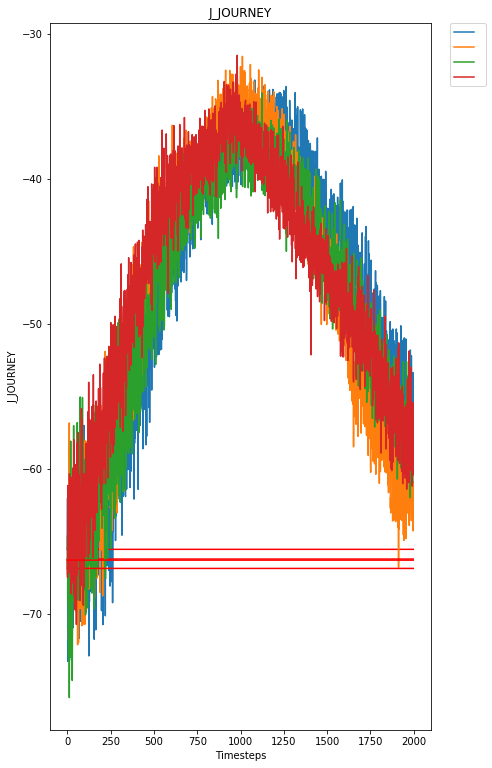

In [358]:
my_plot(value=['J_JOURNEY'], df=p)

# Final results

In [363]:
#BASE_FOLDER = 'experiments_non_exact'
BASE_FOLDER = 'EXPERIMENTS_FINAL_2/'

df_final = load_dataframe(BASE_FOLDER)

In [364]:
df_final['EXPERIMENT'].unique()

array(['MonotonicZeroBudgetEveryStep', 'ExpBudget_SemiDetPolicy',
       'SimultaneousThetaAndSigma', 'ExpBudget_DetPolicy',
       'NoWorseThanBaselineEveryStep', 'MonotonicThetaAndSigma',
       'MonotonicOnlyTheta', 'ExpBudget_NoDetPolicy'], dtype=object)

Budget is negative for:  2969 / 4000  times
Initial J+J_DET is:  -112.90750937378785
Average J+J_DET is:  -106.58322362100418


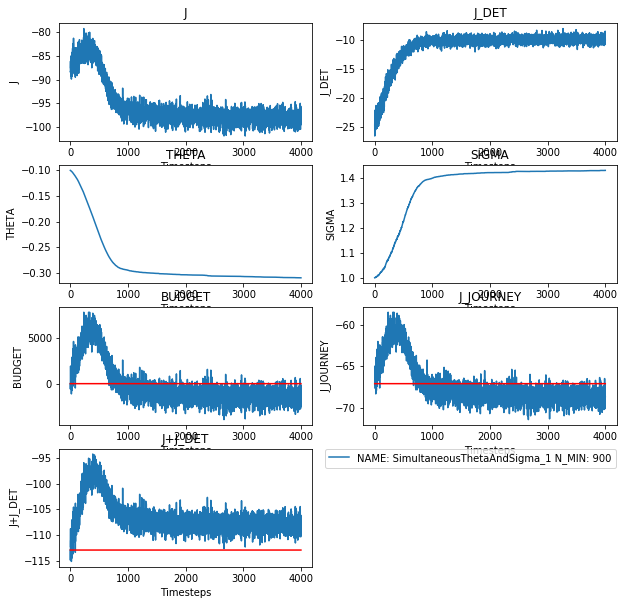

In [553]:
plt.figure(figsize=(10, 10))
my_plot(value=['J', 'J_DET', 'THETA', 'SIGMA', 'BUDGET', 'J_JOURNEY', 'J+J_DET'], 
        #value = ['J_DET', 'J+J_DET', 'J_JOURNEY+J_DET', 'J_JOURNEY', 'BUDGET'],
        min_t = 0,
        max_t=-1,
        #name=['MonotonicZeroBudgetEveryStep_1', 'ExpBudget_SemiDetPolicy_1','SimultaneousThetaAndSigma_1', 'ExpBudget_DetPolicy_1','NoWorseThanBaselineEveryStep_1', 'MonotonicThetaAndSigma_1','MonotonicOnlyTheta_1', 'ExpBudget_NoDetPolicy_1'],
        name = ['SimultaneousThetaAndSigma_1'],
        alpha=1,
        n_min=None,
        df = df_final)

In [375]:
df_final['EXPERIMENT'].unique()

array(['MonotonicZeroBudgetEveryStep', 'ExpBudget_SemiDetPolicy',
       'SimultaneousThetaAndSigma', 'ExpBudget_DetPolicy',
       'NoWorseThanBaselineEveryStep', 'MonotonicThetaAndSigma',
       'MonotonicOnlyTheta', 'ExpBudget_NoDetPolicy'], dtype=object)

Budget is negative for:  2905 / 4000  times
Budget is negative for:  2759 / 4000  times
Budget is negative for:  2328 / 4000  times
Budget is negative for:  2449 / 4000  times


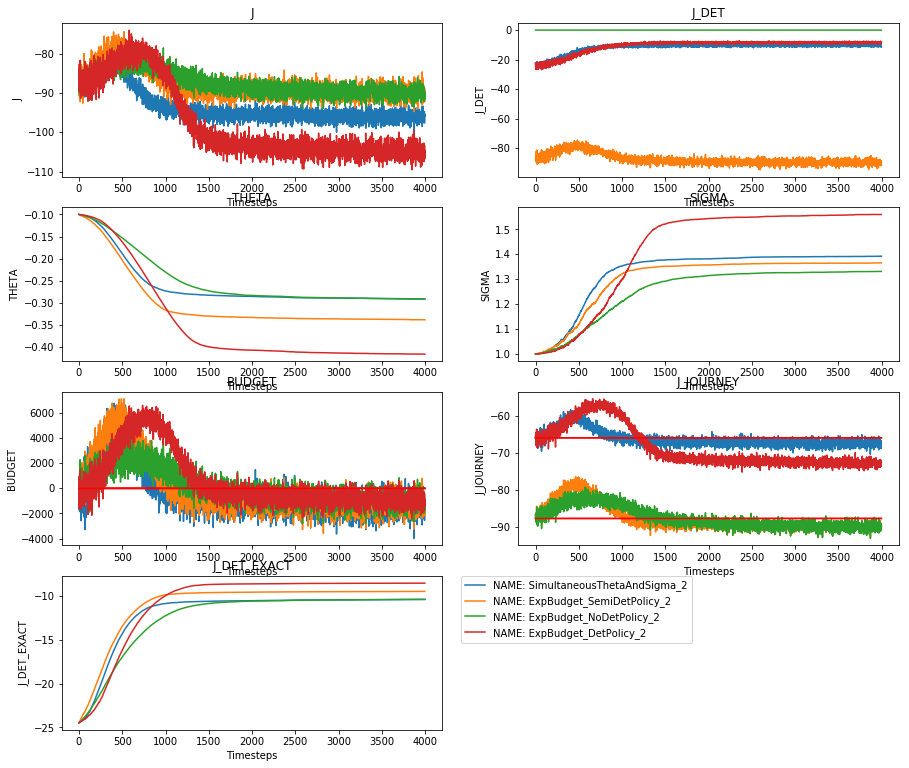

In [393]:
#BASE_FOLDER = 'experiments_non_exact'
BASE_FOLDER = 'EXPERIMENTS_FINAL_2/'

dd = load_dataframe(BASE_FOLDER)

my_plot(value=['J', 'J_DET', 'THETA', 'SIGMA', 'BUDGET', 'J_JOURNEY', 'J_DET_EXACT'], 
        min_t = 0,
        max_t=-1,
#        name=None,
        name = ['ExpBudget_NoDetPolicy_2', 'ExpBudget_DetPolicy_2', 'ExpBudget_SemiDetPolicy_2', 'SimultaneousThetaAndSigma_2'],
        alpha=1,
        df = dd)

In [395]:
dd['EXPERIMENT'].unique()

array(['MonotonicZeroBudgetEveryStep', 'ExpBudget_SemiDetPolicy',
       'SimultaneousThetaAndSigma', 'ExpBudget_DetPolicy',
       'NoWorseThanBaselineEveryStep', 'MonotonicThetaAndSigma',
       'MonotonicOnlyTheta', 'ExpBudget_NoDetPolicy'], dtype=object)

Budget is negative for:  0 / 4000  times
Budget is negative for:  0 / 4000  times


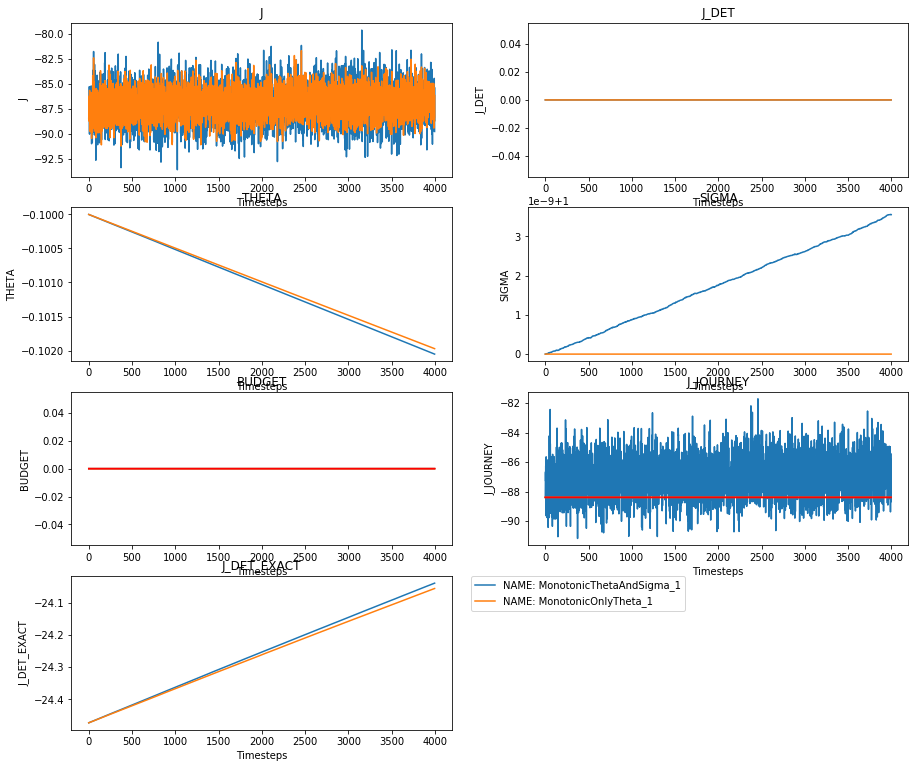

In [398]:
#BASE_FOLDER = 'experiments_non_exact'
BASE_FOLDER = 'EXPERIMENTS_FINAL_2/'

dd = load_dataframe(BASE_FOLDER)

my_plot(value=['J', 'J_DET', 'THETA', 'SIGMA', 'BUDGET', 'J_JOURNEY', 'J_DET_EXACT'], 
        min_t = 0,
        max_t=-1,
#        name=None,
        #name = ['MonotonicOnlyTheta_1', 'MonotonicThetaAndSigma_1', 'MonotonicZeroBudgetEveryStep_1', 'NoWorseThanBaselineEveryStep_1'],
        name = ['MonotonicOnlyTheta_1', 'MonotonicThetaAndSigma_1'],
        alpha=1,
        df = dd)

Budget is negative for:  865 / 2000  times
Budget is negative for:  0 / 2000  times
Budget is negative for:  556 / 2000  times
Budget is negative for:  242 / 2000  times
Budget is negative for:  329 / 2000  times


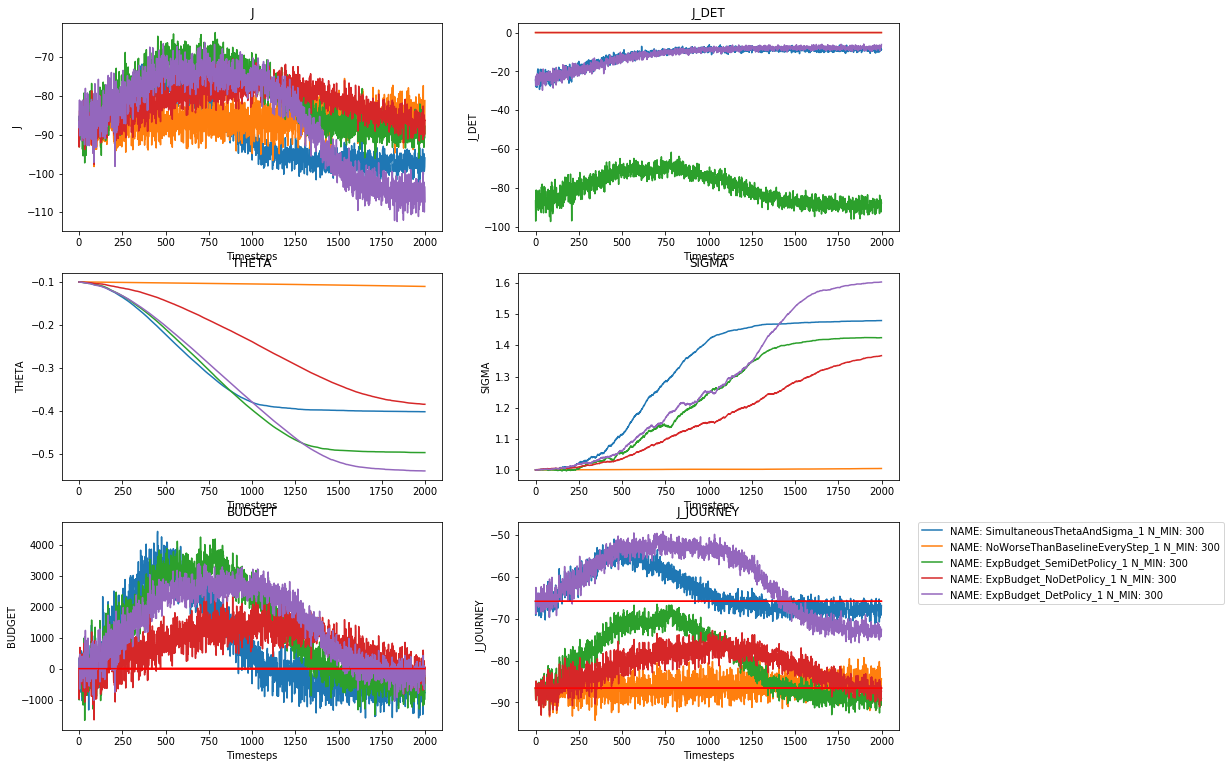

In [558]:
#BASE_FOLDER = 'experiments_non_exact'
BASE_FOLDER = 'EXPERIMENTS_FINAL_MINE/'

dd = load_dataframe(BASE_FOLDER)

my_plot(value=['J', 'J_DET', 'THETA', 'SIGMA', 'BUDGET', 'J_JOURNEY'], 
        min_t = 0,
        max_t=-1,
#        name=None,
        name = ['ExpBudget_NoDetPolicy_1', 'ExpBudget_DetPolicy_1', 'ExpBudget_SemiDetPolicy_1', 'SimultaneousThetaAndSigma_1', 'NoWorseThanBaselineEveryStep_1'],
        alpha=1,
        n_min=None,
        df = dd)

In [405]:
data = load_from_dataframe(filter_experiments(df=ddd, name='PROVA_J_JOURNEY'))[0]

In [406]:
data

T  GRAD_THETA     GRAD_W   GRAD_MIXED  GRAD_DELTAW          J      J_DET  \
0  0 -253.584867 -30.059287  1387.781144    -0.001042 -92.253643 -25.223212   
1  1 -206.975476 -70.208909   302.689354    -0.000059 -80.626130 -24.213326   

          ALPHA      BETA   N     THETA     SIGMA      BUDGET  N2  \
0  0.000000e+00  0.000000  40 -0.100000  1.000000    0.000000  13   
1  3.749219e-09  2.638981  40 -0.100001  0.999304  154.912421  13   

     J_JOURNEY  J_DET_EXACT  
0   -69.910166   -24.472489  
1 -1080.947340   -24.472284

Budget is negative for:  252 / 2000  times
Budget is negative for:  252 / 2000  times
Budget is negative for:  1 / 2  times
Initial J+J_DET is:  -113.92655172002313
Average J+J_DET is:  -95.42001236233044
Initial J+J_DET is:  -113.92655172002314
Average J+J_DET is:  -95.42001236233038
Initial J+J_DET is:  -101.64694347245594
Average J+J_DET is:  -104.18235313270023


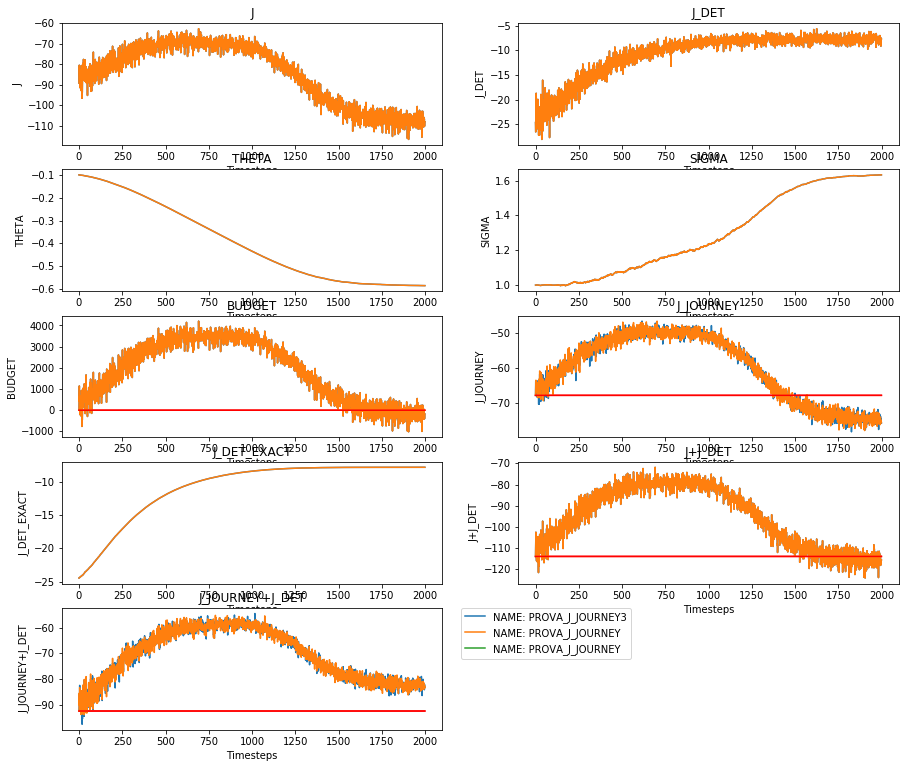

In [539]:
#BASE_FOLDER = 'experiments_non_exact'
BASE_FOLDER = 'prova/'

ddd = load_dataframe(BASE_FOLDER)

my_plot(value=['J', 'J_DET', 'THETA', 'SIGMA', 'BUDGET', 'J_JOURNEY', 'J_DET_EXACT', 'J+J_DET', 'J_JOURNEY+J_DET'], 
        min_t = 0,
        max_t=-1,
#        name=None,
        name = ['PROVA_J_JOURNEY', 'PROVA_J_JOURNEY3'],
        alpha=1,
        df = ddd)

In [508]:
data = load_from_dataframe(filter_experiments(df = ddd, name = ['PROVA_J_JOURNEY4', 'PROVA_J_JOURNEY3']))

In [510]:
d0 = data[0]
d1 = data[1]

In [511]:
d0['J+J_DET'] = d0['J'] + d0['J_DET']

In [512]:
d1['J+J_DET'] = d1['J'] + d1['J_DET']

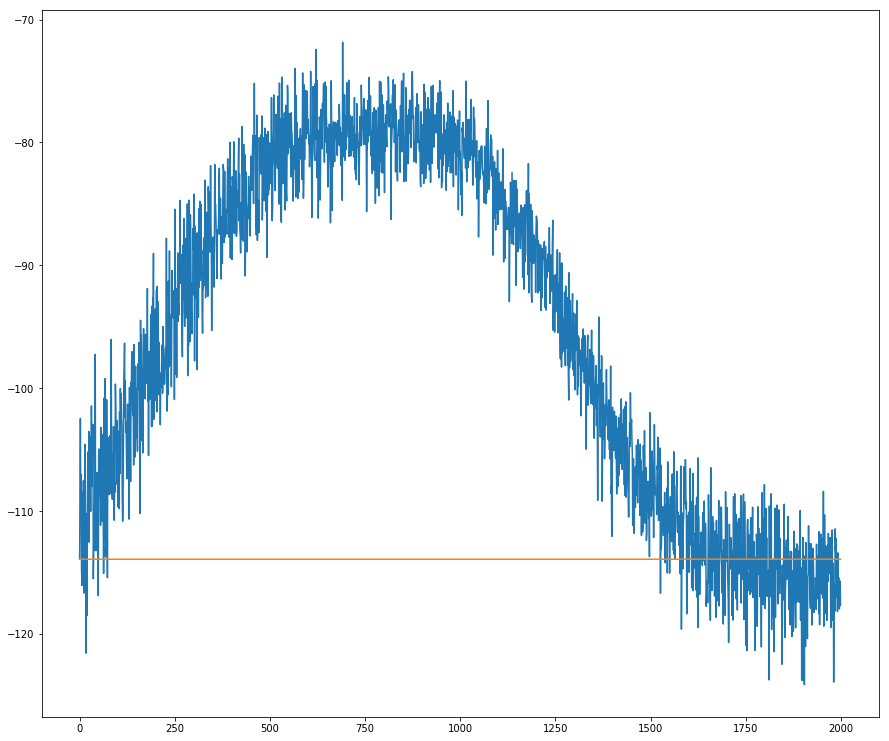

In [519]:
plt.plot(d0['T'], d0['J+J_DET'])
plt.plot(d0['T'], [d0['J+J_DET'][0]] * len(d0['T']))

In [506]:
#BASE_FOLDER = 'experiments_non_exact'
BASE_FOLDER = 'prova/'

ddd = load_dataframe(BASE_FOLDER)

my_plot(value=['J', 'J_DET', 'THETA', 'SIGMA', 'J+J_DET', 'J_JOURNEY'], 
        min_t = 0,
        max_t=-1,
#        name=None,
        experiment = ['DebugSingleBudget2', 'DebugSingleBudget3'],
        alpha=1,
        step=2,
        df = ddd)

Initial J+J_DET is:  -593.2155477031799
Average J+J_DET is:  -547.2886906235218
Initial J+J_DET is:  -593.2155477031799
Average J+J_DET is:  -547.3111776608256
Initial J+J_DET is:  -593.2155477031799
Average J+J_DET is:  -518.7561215454798
Initial J+J_DET is:  -593.2155477031799
Average J+J_DET is:  -517.160600274394


In [488]:
data = load_from_dataframe(filter_experiments(df = ddd, experiment='DebugSingleBudget2'))[0]

In [489]:
data['J+J_DET'][0]

-593.2155477031799

In [490]:
data['J+J_DET'][1999]

-593.2155477031795

In [501]:
data['J_JOURNEY'][0] + data['J_DET'][0]

-1186.4310954063599

In [500]:
data['J_JOURNEY'][1998] + data['J_DET'][1998]

-1186.4310954063594

In [503]:
data['J_JOURNEY'][1]

-593.1387686696755

In [504]:
data['J_JOURNEY'][1999]

-593.2155477031795

Initial J+J_DET is:  -113.92655172002313
Average J+J_DET is:  -103.59028404752436
Initial J+J_DET is:  -113.13895811341999
Average J+J_DET is:  -98.22902207498811
Initial J+J_DET is:  -113.13895811341999
Average J+J_DET is:  -101.46695962812348
Initial J+J_DET is:  -111.72794999408646
Average J+J_DET is:  -97.66894813626082
Initial J+J_DET is:  -113.92655172002313
Average J+J_DET is:  -95.3562809946262
Initial J+J_DET is:  -108.28692525374339
Average J+J_DET is:  -94.16960596012572


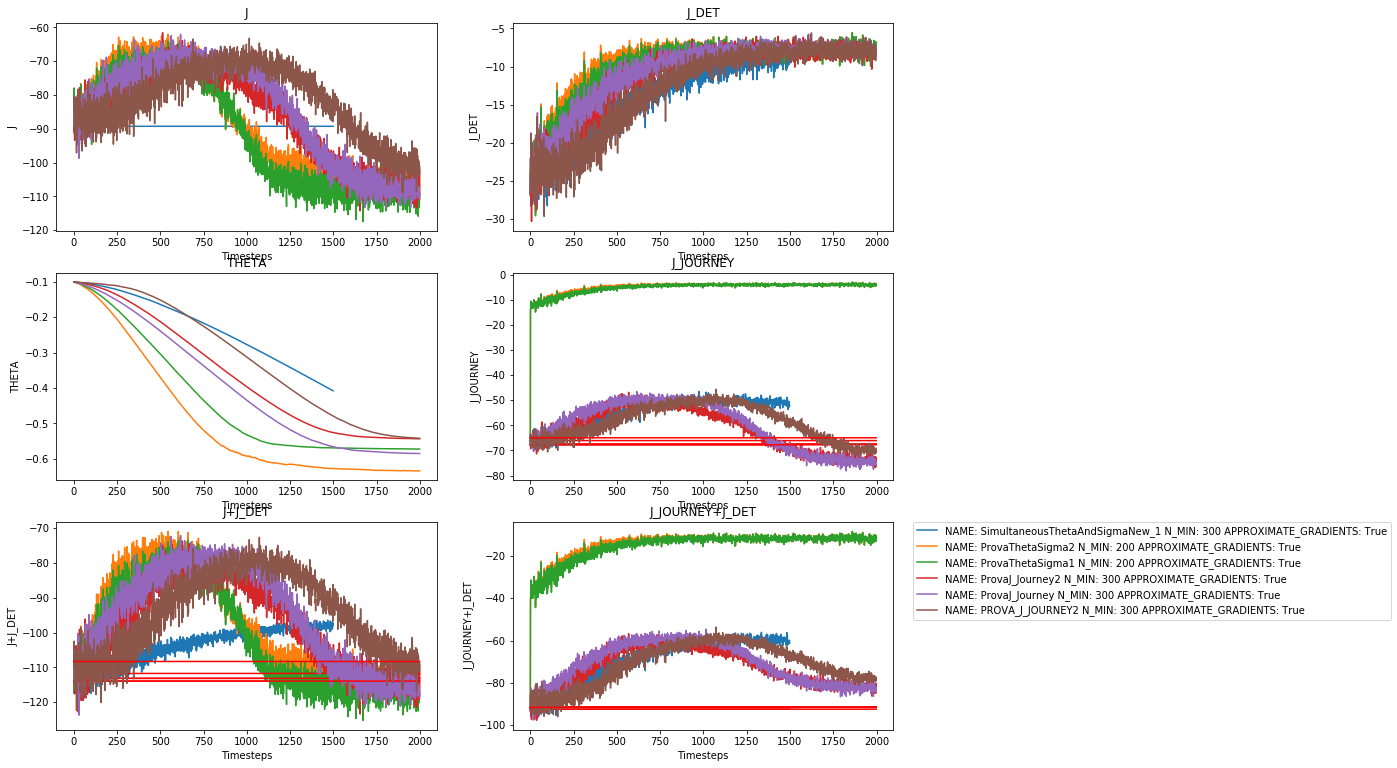

In [24]:
#BASE_FOLDER = 'experiments_non_exact'
BASE_FOLDER = 'prova/'

ddd = load_dataframe(BASE_FOLDER)

my_plot(value=['J', 'J_DET', 'THETA', 'J_JOURNEY', 'J+J_DET', 'J_JOURNEY+J_DET'], 
        min_t = 0,
        max_t=-1,
#        name=None,
        name = ['SimultaneousThetaAndSigmaNew_1', 'PROVA_J_JOURNEY2', 'ProvaThetaSigma1', 'ProvaThetaSigma2', 'ProvaJ_Journey', 'ProvaJ_Journey2'],
        alpha=1,
        n_min=None,
        APPROXIMATE_GRADIENTS=None,
        df = ddd)

In [6]:
df = load_dataframe('EXPERIMENTS_FINAL_LONG/')

In [12]:
df['EXPERIMENT'].unique()

array(['ExpBudget_NoDetPolicy',
       'SimultaneousThetaAndSigma_two_thirds_theta',
       'NoWorseThanBaselineEveryStep', 'MonotonicZeroBudgetEveryStep',
       'MonotonicThetaAndSigma',
       'SimultaneousThetaAndSigma_two_thirds_sigma',
       'ExpBudget_SemiDetPolicy', 'MonotonicOnlyTheta',
       'SimultaneousThetaAndSigma_half', 'ExpBudget_DetPolicy'],
      dtype=object)

Initial J+J_DET is:  -108.80119473103125
Average J+J_DET is:  -111.69130324137058
Initial J+J_DET is:  -85.03794233572447
Average J+J_DET is:  -85.576682916444
Initial J+J_DET is:  -86.5720466751432
Average J+J_DET is:  -86.57012297877344
Initial J+J_DET is:  -85.6350547209396
Average J+J_DET is:  -87.3018375177622
Initial J+J_DET is:  -110.58722128634828
Average J+J_DET is:  -111.23250786269612


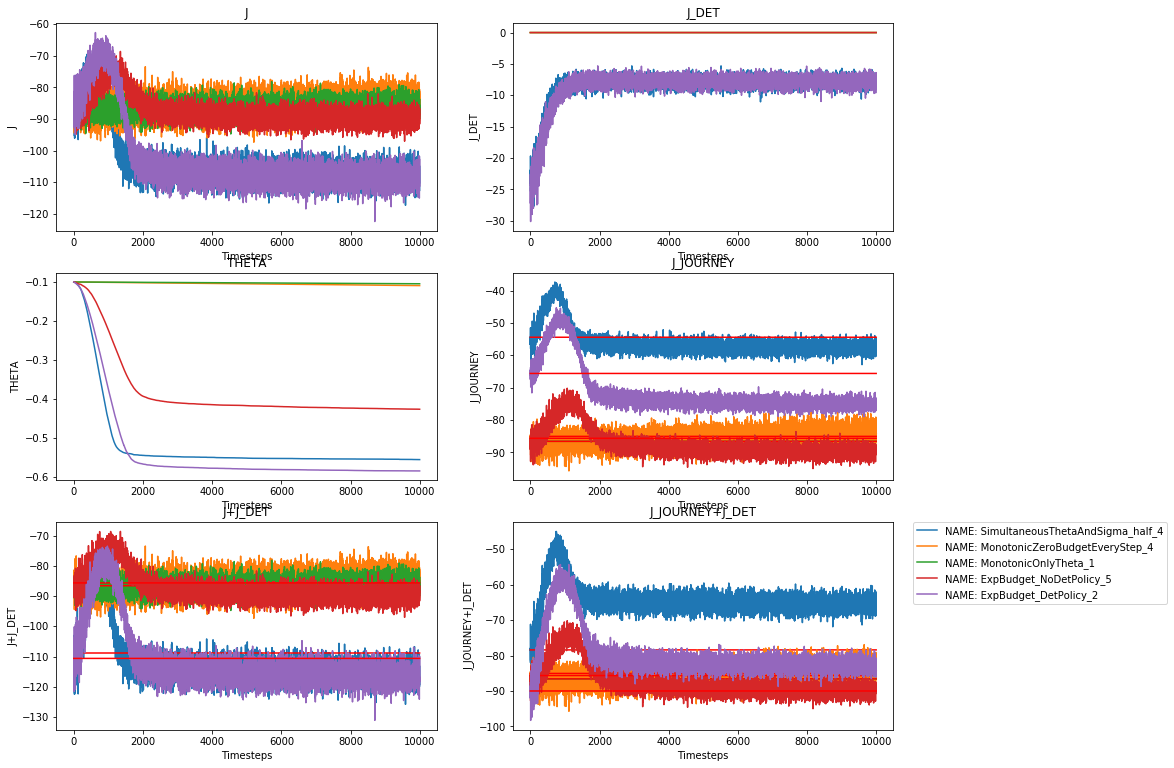

In [11]:
my_plot(value=['J', 'J_DET', 'THETA', 'J_JOURNEY', 'J+J_DET', 'J_JOURNEY+J_DET'], 
        min_t = 0,
        max_t=-1,
        name=['SimultaneousThetaAndSigma_half_4', 'ExpBudget_DetPolicy_2', 'ExpBudget_NoDetPolicy_5','MonotonicZeroBudgetEveryStep_4', 'MonotonicOnlyTheta_1'],
        df = df)

In [13]:
df2 = load_dataframe('GRID_LQG_CONFIDENCE/')

In [18]:
df2['EXPERIMENT'].unique()

array(['Adam', 'NoWorseThanBaselineEveryStep', 'MonotonicNaiveGradient',
       'ExpBudget_NoDetPolicy', 'MonotonicOnlyTheta'], dtype=object)

Initial J+J_DET is:  -127.3783847012752
Average J+J_DET is:  -98.94470090958718
Initial J+J_DET is:  -132.73022489913973
Average J+J_DET is:  -74.92370442383526
Initial J+J_DET is:  -134.13809123137386
Average J+J_DET is:  -45.210551135457045


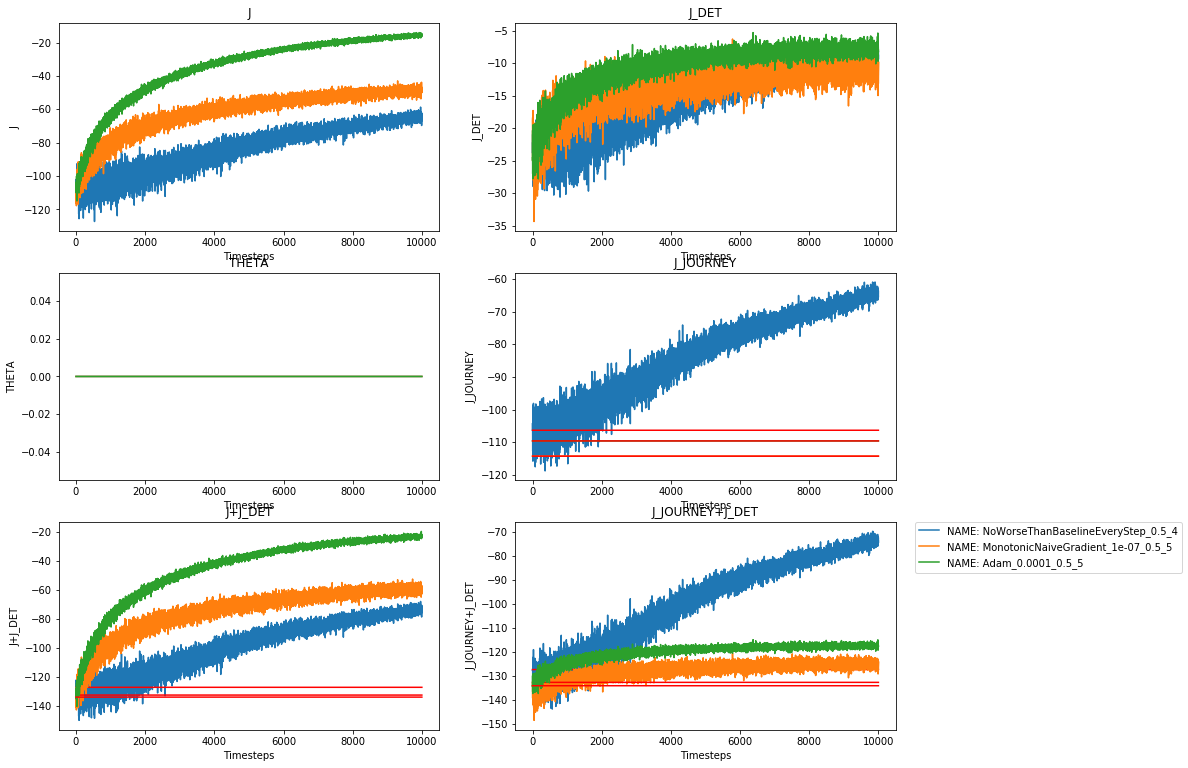

In [17]:
my_plot(value=['J', 'J_DET', 'THETA', 'J_JOURNEY', 'J+J_DET', 'J_JOURNEY+J_DET'], 
        min_t = 0,
        max_t=-1,
        name=['Adam_0.0001_0.5_5', 'NoWorseThanBaselineEveryStep_0.5_4', 'MonotonicNaiveGradient_1e-07_0.5_5'],
        df = df2)